In [2]:
import pandas as pd
import io
import os
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import hilbert
from scipy.stats import skew, kurtosis

import mplfinance as mpf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import kaleido




## Initial Setup

In [4]:
df_5min = pd.read_csv('/Users/abaml/Documents/zelta/data/data/btcusdt_5m_train.csv')
df_5min.rename(columns={'datetime': 'Date'}, inplace=True)
df_5min['Date'] = pd.to_datetime(df_5min['Date'])
df_5min.set_index('Date', inplace=True)
df_5min

Unnamed: 0      open      high       low     close  \
Date                                                                      
2018-01-01 05:30:00           0  13715.65  13715.65  13576.28  13600.00   
2018-01-01 05:35:00           1  13600.00  13600.00  13501.01  13554.58   
2018-01-01 05:40:00           2  13554.58  13569.97  13400.01  13556.15   
2018-01-01 05:45:00           3  13533.75  13547.73  13402.00  13430.52   
2018-01-01 05:50:00           4  13440.01  13459.99  13410.44  13439.94   
...                         ...       ...       ...       ...       ...   
2021-05-31 23:40:00      357549  36849.04  36878.94  36750.46  36759.67   
2021-05-31 23:45:00      357550  36759.89  36835.99  36730.00  36801.92   
2021-05-31 23:50:00      357551  36801.93  36874.39  36677.37  36774.13   
2021-05-31 23:55:00      357552  36774.13  36820.46  36715.00  36758.45   
2021-06-01 00:00:00      357553  36758.45  36795.56  36710.08  36727.36   

                         volume  
Date                             
2018-01-01 05:30:00   33.617798  
2018-01-01 05:35:00   40.528679  
2018-01-01 05:40:00   49.469536  
2018-01-01 05:45:00   32.725614  
2018-01-01 05:50:00   26.614135  
...                         ...  
2021-05-31 23:40:00  221.044999  
2021-05-31 23:45:00  187.001455  
2021-05-31 23:50:00  271.955089  
2021-05-31 23:55:00  118.104723  
2021-06-01 00:00:00  118.790547  

[357554 rows x 6 columns]

In [5]:
df = pd.read_csv('/Users/abaml/Documents/zelta/data/data/btcusdt_15m_train.csv')
df.rename(columns={'datetime': 'Date'}, inplace=True)
print(df)

        Unnamed: 0                 Date      open      high       low  \
0                0  2018-01-01 05:30:00  13715.65  13715.65  13400.01   
1                1  2018-01-01 05:45:00  13533.75  13550.87  13402.00   
2                2  2018-01-01 06:00:00  13500.00  13545.37  13450.00   
3                3  2018-01-01 06:15:00  13494.65  13690.87  13450.00   
4                4  2018-01-01 06:30:00  13528.99  13571.74  13402.28   
...            ...                  ...       ...       ...       ...   
119185      119185  2021-05-31 23:00:00  36869.99  36906.96  36673.41   
119186      119186  2021-05-31 23:15:00  36782.96  36949.80  36707.33   
119187      119187  2021-05-31 23:30:00  36935.81  36955.02  36750.46   
119188      119188  2021-05-31 23:45:00  36759.89  36874.39  36677.37   
119189      119189  2021-06-01 00:00:00  36758.45  36795.56  36629.53   

           close      volume  
0       13556.15  123.616013  
1       13521.12   98.136430  
2       13470.41   79.904037  

In [5]:
# Convert the 'Date' column to datetime if it's not already in that format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index of the DataFrame
df.set_index('Date', inplace=True)

# Now perform the resampling
df_daily = df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Reset the index if you want 'Date' back as a column
df_daily.reset_index(inplace=True)

## Statistical Analysis

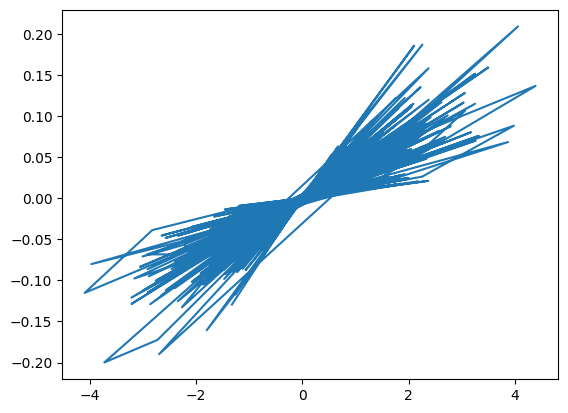

In [11]:
df_daily['Return'] = df_daily['close'].pct_change()
df_daily['Rolling_Std_20'] = df_daily['Return'].rolling(window=20).std()
df_daily['Custom']=df_daily['Return']/df_daily['Rolling_Std_20']
plt.plot(df_daily['Custom'],df_daily['Return'])

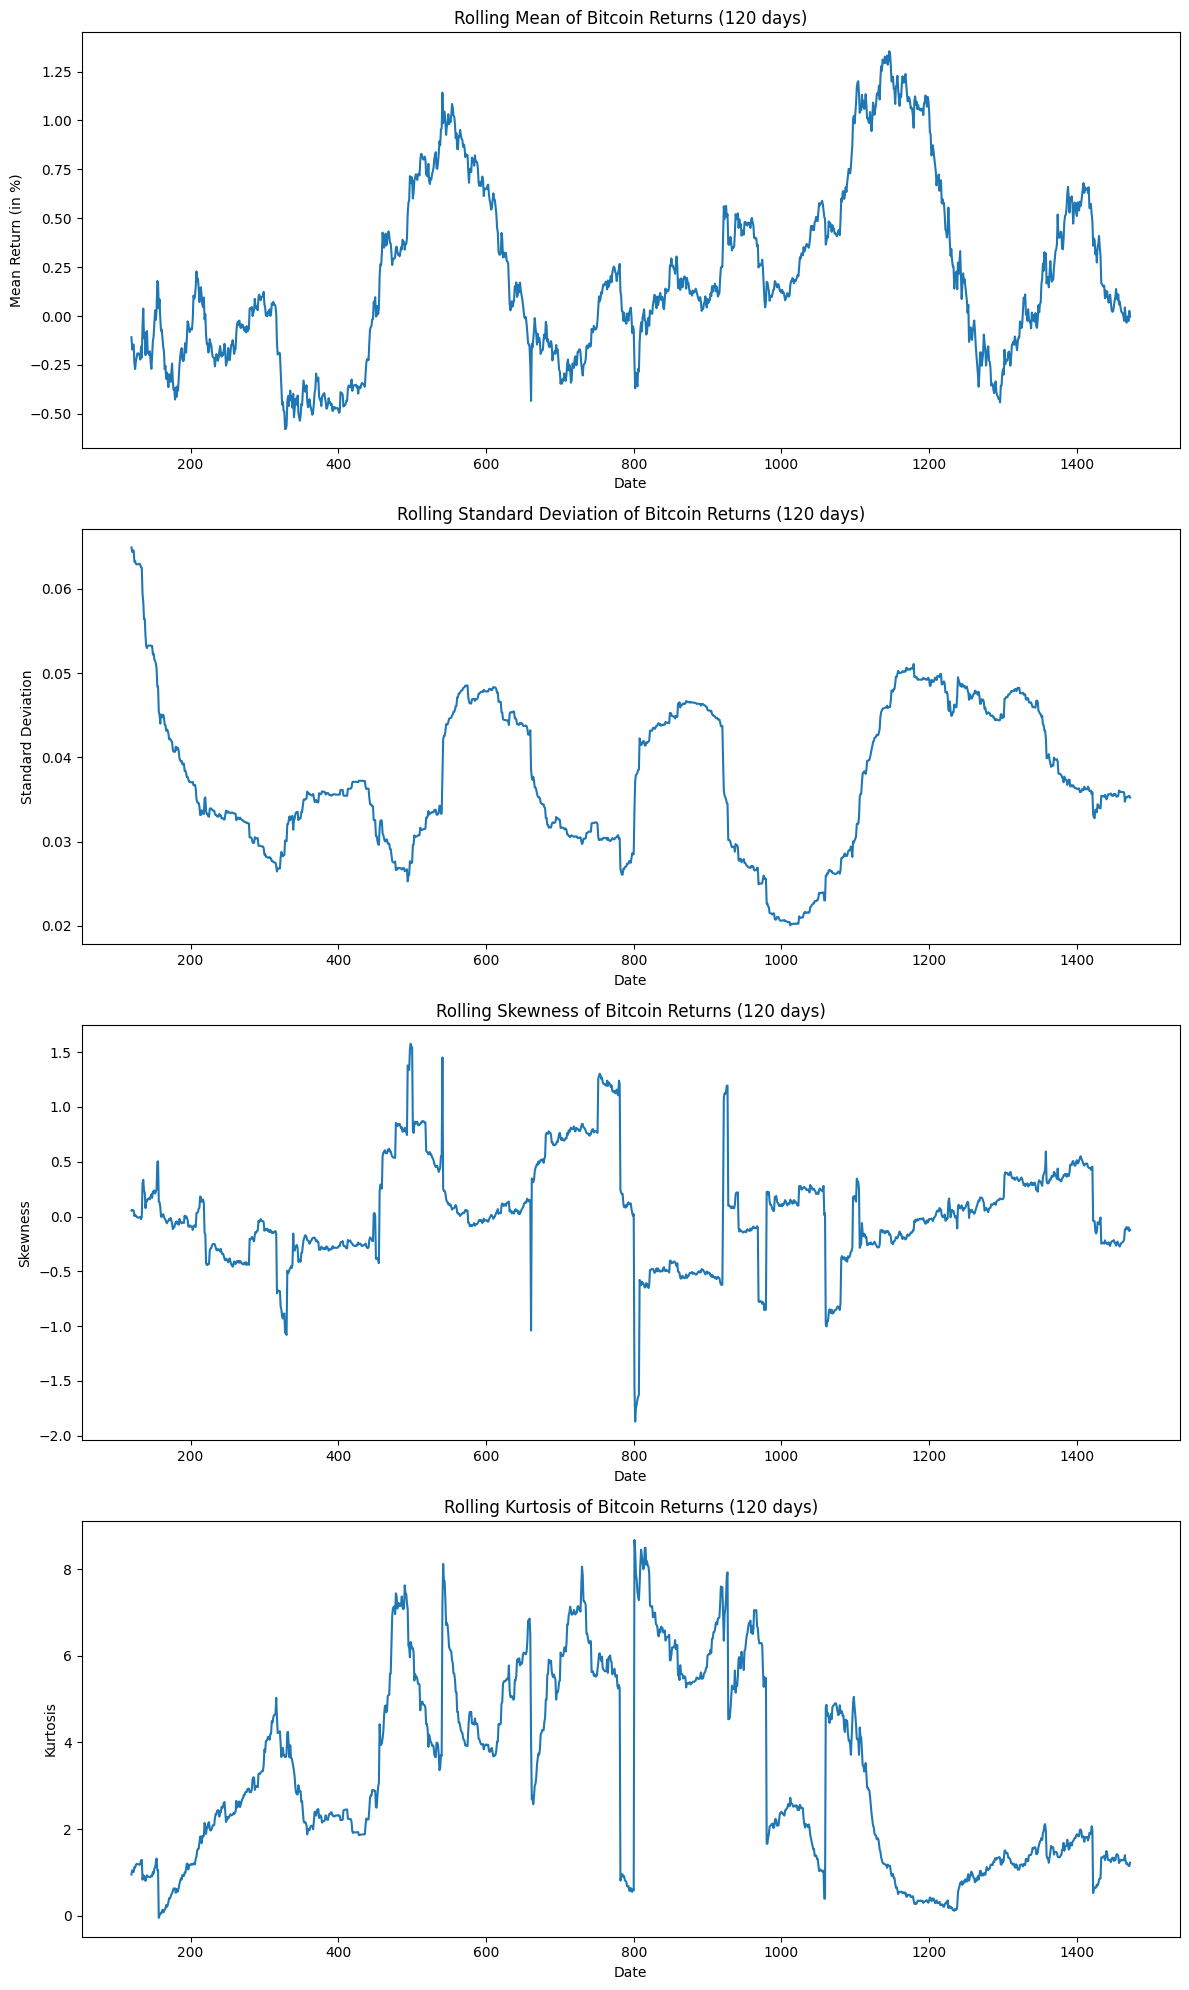

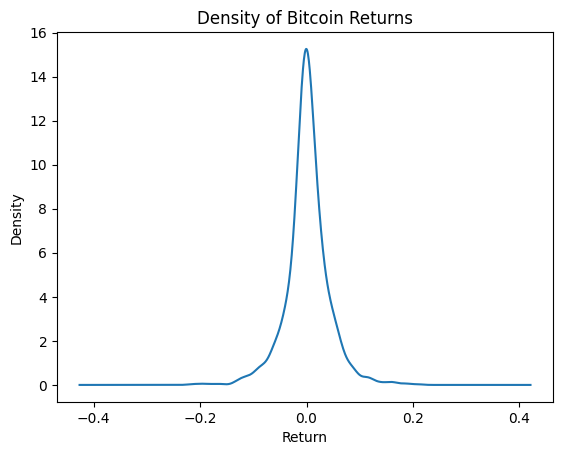

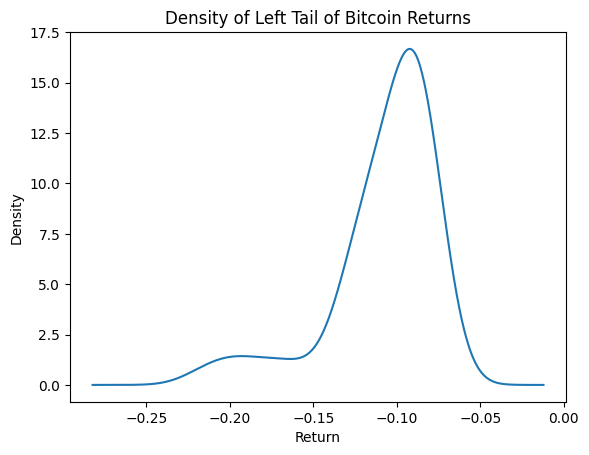

In [12]:
# Calculate daily returns as percentage change in the closing price
df_daily['Return'] = df_daily['close'].pct_change()

# Define the rolling window size
rolling_window = 120

# Calculate rolling statistics
df_daily['Rolling_Mean'] = (df_daily['Return'].rolling(window=rolling_window).mean())*100
df_daily['Rolling_Std'] = df_daily['Return'].rolling(window=rolling_window).std()
df_daily['Rolling_Skewness'] = df_daily['Return'].rolling(window=rolling_window).apply(skew, raw=True)
df_daily['Rolling_Kurtosis'] = df_daily['Return'].rolling(window=rolling_window).apply(kurtosis, raw=True)

# Plotting the rolling statistics
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

df_daily['Rolling_Mean'].plot(ax=axes[0], title='Rolling Mean of Bitcoin Returns (120 days)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Mean Return (in %)')

df_daily['Rolling_Std'].plot(ax=axes[1], title='Rolling Standard Deviation of Bitcoin Returns (120 days)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Standard Deviation')

df_daily['Rolling_Skewness'].plot(ax=axes[2], title='Rolling Skewness of Bitcoin Returns (120 days)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Skewness')

df_daily['Rolling_Kurtosis'].plot(ax=axes[3], title='Rolling Kurtosis of Bitcoin Returns (120 days)')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Kurtosis')

plt.tight_layout()
plt.show()

# Density plot of returns
df_daily['Return'].plot(kind='density', title='Density of Bitcoin Returns')
plt.xlabel('Return')
plt.show()

# Density plot of left tail returns
left_tail = df_daily['Return'][df_daily['Return'] < df_daily['Return'].mean() - 2 * df_daily['Return'].std()]
left_tail.plot(kind='density', title='Density of Left Tail of Bitcoin Returns')
plt.xlabel('Return')
plt.show()

##### Rolling Mean (120 days): The mean of the returns is very close to zero, indicating that there is no significant upward or downward trend in the average returns over the 120-day period.

##### Rolling Standard Deviation (120 days): The standard deviation is relatively steady, suggesting a consistent level of volatility in the Bitcoin returns over the observed period. With values around 0.035, this indicates a moderate level of volatility, which is typical for cryptocurrency markets.

##### Rolling Skewness (120 days): The skewness values are slightly negative, indicating a small inclination towards more frequent extreme negative returns. However, since the values are close to zero, the returns distribution is fairly symmetrical.

##### Rolling Kurtosis (120 days): The kurtosis values are slightly above 1, suggesting that the distribution of returns has heavier tails than a normal distribution. This implies a higher risk of extreme returns, both positive and negative, though not excessively so.

##### The densitsy plots provide a visual representation of the return distribution. The overall density plot shows the distribution of all returns, whereas the density plot of the left tail focuses on the negative returns that are more extreme, which can be important for assessing the risk of substantial negative movements in price.

In [13]:
# Optionally, change the working directory to where the notebook is located
notebook_path = os.path.dirname(os.path.abspath("__file__"))  # Get the directory of the notebook
os.chdir(notebook_path)  # Change the current working directory to the notebook path

# Save the DataFrame to a CSV file
df_daily.to_csv('my_exported_data.csv', index=False)


## FOMC Meeting Analysis


#### 2018
January30-31 | March20-21* | May1-2 | June12-13* | Jul/Aug31-1 | September25-26* | 
November7-8 | December18-19* 

#### 2019
January 29-30 | March 19-20* | April/May 30-1 | June 18-19* | Jul-31 | September 17-18* | 
October4 (unscheduled) | October29-30 | December10-11*

#### 2020
January 28-29 | March 3(unscheduled) | March 15(unscheduled) | March17-18* (cancelled)
March19 (notation vote)| March23 (notation vote) March31 (notation vote) | April 28-29 | June 9-10* | Jul 28-29 | August27 (notation vote)| September 15-16* | November 4-5 | December 15-16*

#### 2021
January 26-27 | March 16-17* | April 27-28| June 15-16* | Jul 27-28 | September 21-22* | 
November 2-3 | December 14-15* 

#### 2022
January 25-26 | March 15-16* | May 3-4 | June 14-15* | Jul 26-27 | September 20-21* | 
November 1-2 | December 13-14* 

*Meeting associated with a Summary of Economic Projections and a press conference by the Chair.



In [14]:
# Define the FOMC meeting dates from 2018 to 2022
fomc_dates = [
    # 2018
    "2018-01-31", "2018-03-21", "2018-05-02", "2018-06-13",
    "2018-08-01", "2018-09-26", "2018-11-08", "2018-12-19",
    # 2019
    "2019-01-30", "2019-03-20", "2019-05-01", "2019-06-19",
    "2019-07-31", "2019-09-18", "2019-10-04", "2019-10-30", "2019-12-11",
    # 2020
    "2020-01-29", "2020-03-03", "2020-03-15", "2020-03-18", # March 18 meeting was cancelled but date included for surrounding analysis
    "2020-03-19", "2020-03-23", "2020-03-31", "2020-04-29",
    "2020-06-10", "2020-07-29", "2020-08-27", "2020-09-16",
    "2020-11-05", "2020-12-16",
    # 2021
    "2021-01-27", "2021-03-17", "2021-04-28", "2021-06-16",
    "2021-07-28", "2021-09-22", "2021-11-03", "2021-12-15",
    # 2022
    "2022-01-26", "2022-03-16", "2022-05-04", "2022-06-15",
    "2022-07-27", "2022-09-21", "2022-11-02", "2022-12-14",
]

# Convert FOMC dates to datetime
fomc_dates = pd.to_datetime(fomc_dates)

In [15]:
# To extract only the FOMC meeting dates for the year 2018 from the provided list
fomc_2018_dates = [date for date in fomc_dates if date.year == 2018]
fomc_2019_dates = [date for date in fomc_dates if date.year == 2019]
fomc_2020_dates = [date for date in fomc_dates if date.year == 2020]
fomc_2021_dates = [date for date in fomc_dates if date.year == 2021]
fomc_2022_dates = [date for date in fomc_dates if date.year == 2022]


# Now fomc_2018_dates contains only the dates for the year 2018
fomc_2020_dates


[Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-03-03 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-29 00:00:00'),
 Timestamp('2020-06-10 00:00:00'),
 Timestamp('2020-07-29 00:00:00'),
 Timestamp('2020-08-27 00:00:00'),
 Timestamp('2020-09-16 00:00:00'),
 Timestamp('2020-11-05 00:00:00'),
 Timestamp('2020-12-16 00:00:00')]

In [16]:
# Assuming df_daily is already defined and contains the BTC data
# Initialize an empty DataFrame for the impact analysis
btc_fomc_impact = pd.DataFrame()

for date in fomc_dates:
    # Get the range of dates around the FOMC meeting
    start_date = date - pd.Timedelta(days=3)
    end_date = date + pd.Timedelta(days=3)
    # Filter the data
    btc_fomc_data = df_daily[(df_daily['Date'] >= start_date) & (df_daily['Date'] <= end_date)]
    # Append to the master DataFrame using concat
    btc_fomc_impact = pd.concat([btc_fomc_impact, btc_fomc_data], ignore_index=True)

# Now btc_fomc_impact contains the BTC data around the FOMC dates
# We can now perform statistical analysis on this data


In [17]:
btc_fomc_impact.describe(include='all')  # We use 'include=all' to get statistics for all columns including non-numeric ones


Date          open          high  \
count                            273    273.000000    273.000000   
mean   2020-01-20 21:32:18.461538560  16225.081429  16764.129194   
min              2018-01-28 00:00:00   3185.020000   3294.000000   
25%              2019-03-22 00:00:00   6542.480000   6720.000000   
50%              2020-03-15 00:00:00   9121.080000   9424.050000   
75%              2020-11-03 00:00:00  13745.000000  13864.000000   
max              2021-12-18 00:00:00  63372.850000  64270.000000   
std                              NaN  16422.869371  16914.755385   

                low         close         volume      Return  Rolling_Std_20  \
count    273.000000    273.000000     273.000000  273.000000      273.000000   
mean   15732.339121  16292.779414   66028.486993    0.005052        0.040406   
min     3176.000000   3229.980000    7690.227838   -0.199886        0.008911   
25%     6430.000000   6535.500000   33164.794271   -0.016183        0.025401   
50%     8950.000000   9140.050000   48289.715516    0.002778        0.035467   
75%    13284.990000  13745.000000   79378.236859    0.023379        0.048691   
max    60723.000000  63374.600000  415317.835441    0.186971        0.094126   
std    15905.631298  16452.990209   52057.227331    0.043424        0.020114   

           Custom  Rolling_Mean  Rolling_Std  Rolling_Skewness  \
count  273.000000    257.000000   257.000000        257.000000   
mean     0.147374      0.156776     0.037523         -0.092471   
min     -3.728909     -0.510508     0.020733         -1.870973   
25%     -0.462497     -0.088962     0.030843         -0.401633   
50%      0.070337      0.085273     0.036319          0.000447   
75%      0.762434      0.371966     0.044443          0.213519   
max      3.979062      1.236994     0.064927          1.287858   
std      0.997992      0.388019     0.008740          0.573264   

       Rolling_Kurtosis  
count        257.000000  
mean           3.845087  
min            0.074127  
25%            1.687079  
50%            3.192480  
75%            5.934536  
max            8.671998  
std            2.538599

In [18]:
df_2018 = df_daily[df_daily['Date'].dt.year == 2018]
df_2019 = df_daily[df_daily['Date'].dt.year == 2019]
df_2020 = df_daily[df_daily['Date'].dt.year == 2020]
df_2021 = df_daily[df_daily['Date'].dt.year == 2021]
df_2022 = df_daily[df_daily['Date'].dt.year == 2022]



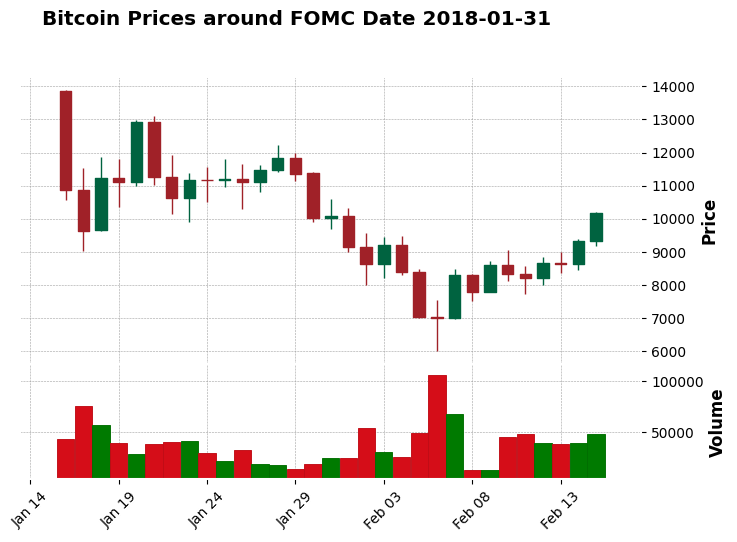

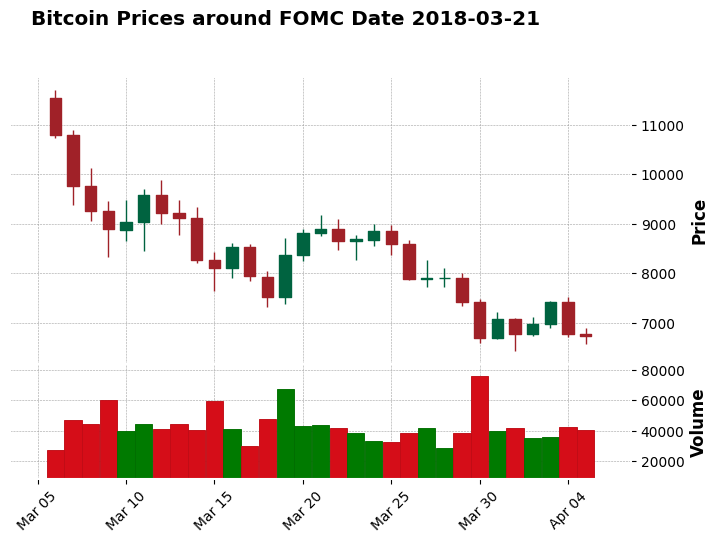

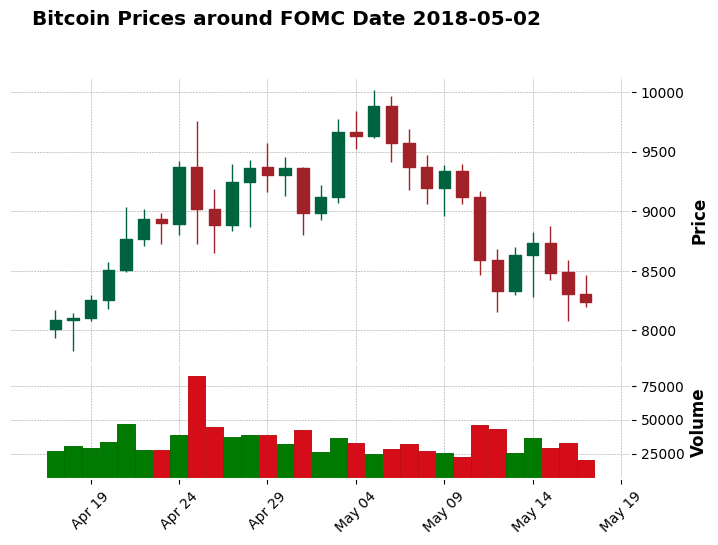

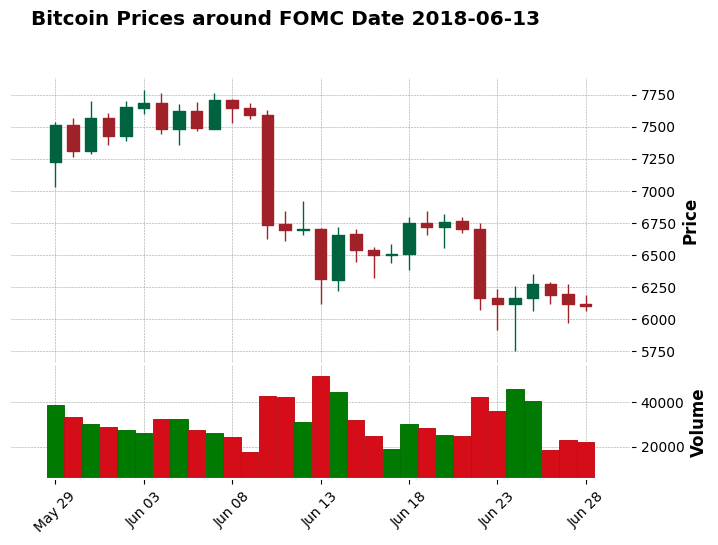

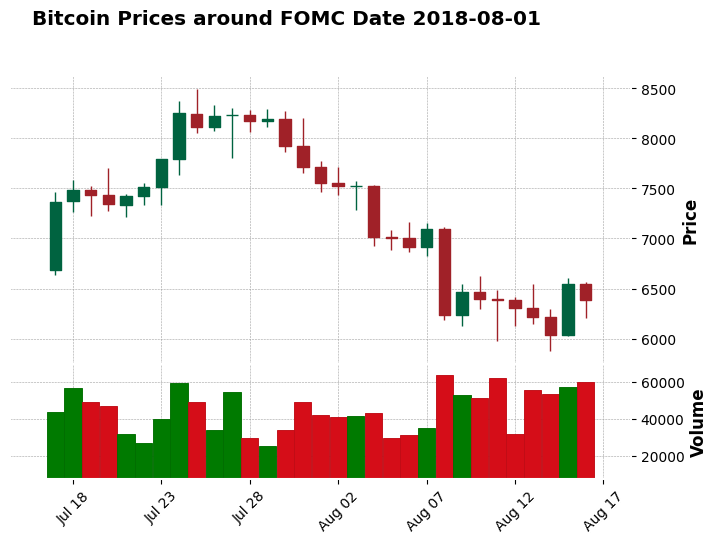

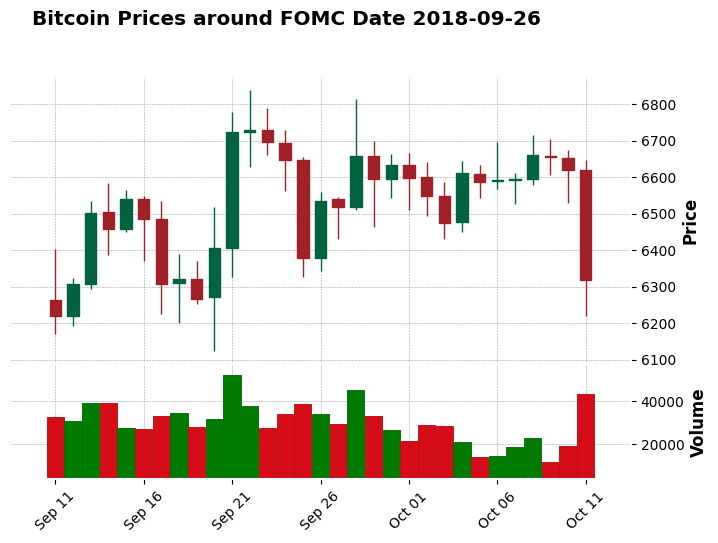

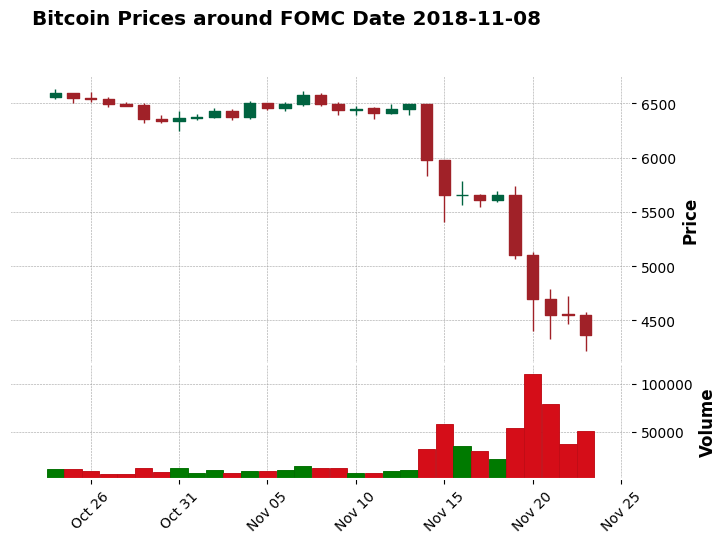

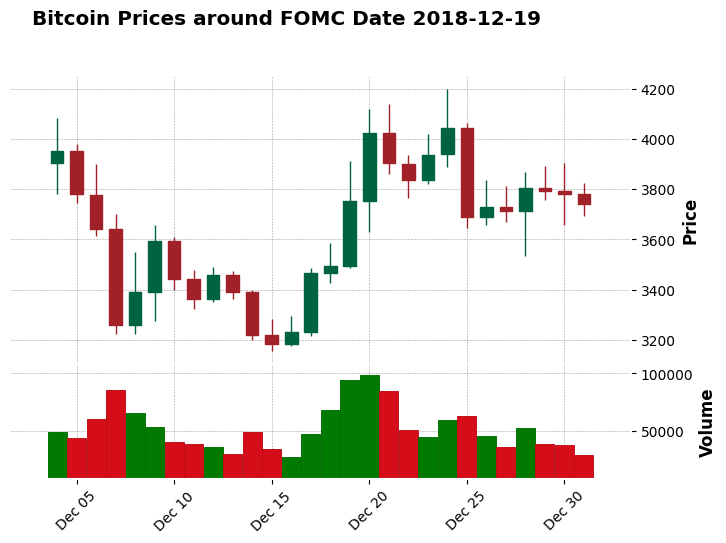

In [20]:
def plot_candlestick_chart_mpl(data, fomc_dates, year):
    # Ensure 'Date' is set as the index
    if 'Date' in data.columns:
        data = data.set_index('Date')
    data.index = pd.to_datetime(data.index)  # Convert the index to datetime

    # Iterate over each FOMC date
    for fomc_date in fomc_dates:
        # Check if FOMC date is in the specified year
        if fomc_date.year != year:
            continue

        # Create a 30-day period around the FOMC date
        start_date = fomc_date - pd.Timedelta(days=15)
        end_date = fomc_date + pd.Timedelta(days=15)

        # Filter data for the 30-day period
        period_data = data[(data.index >= start_date) & (data.index <= end_date)]

        # Skip if no data for the period
        if period_data.empty:
            continue

        # Create a candlestick plot for the 30-day period
        mpf.plot(period_data[['open', 'high', 'low', 'close', 'volume']],
                 type='candle', style='charles',
                 title=f'Bitcoin Prices around FOMC Date {fomc_date.date()}',
                 figratio=(12, 8), volume=True, show_nontrading=True)

        # Show or save the plot as needed
        plt.show()  # or plt.savefig(f'chart_{fomc_date.date()}.png')

# Assuming df_2018 and fomc_2018_dates are already defined
plot_candlestick_chart_mpl(df_2018, fomc_2018_dates, 2018)


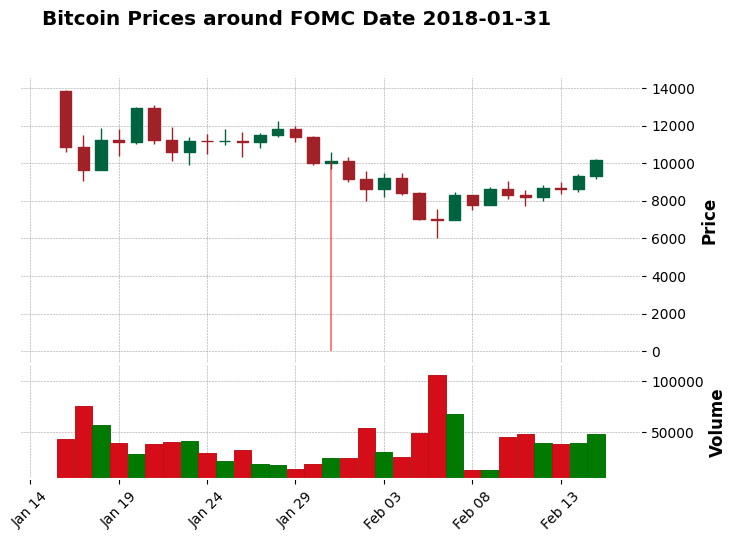

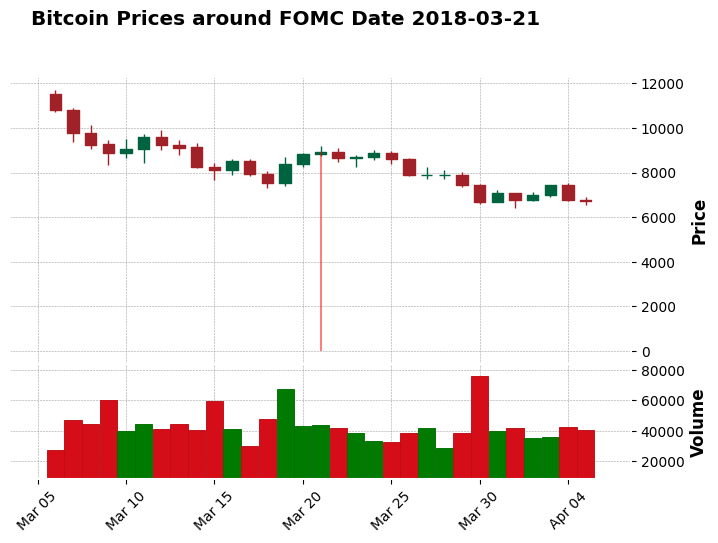

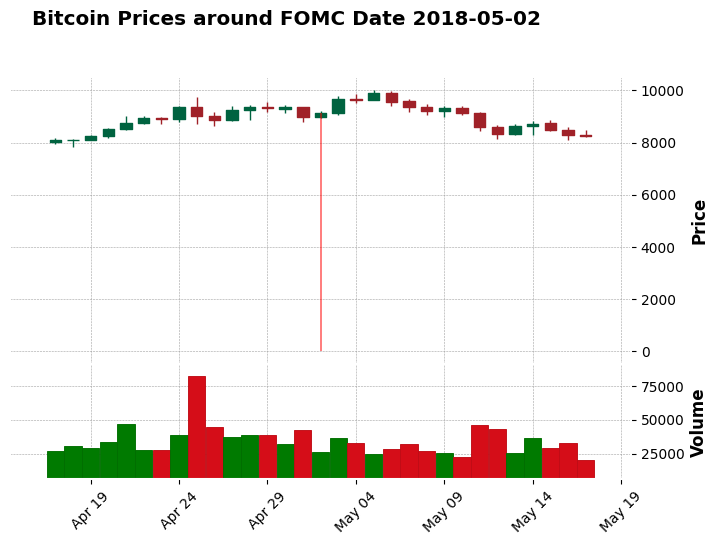

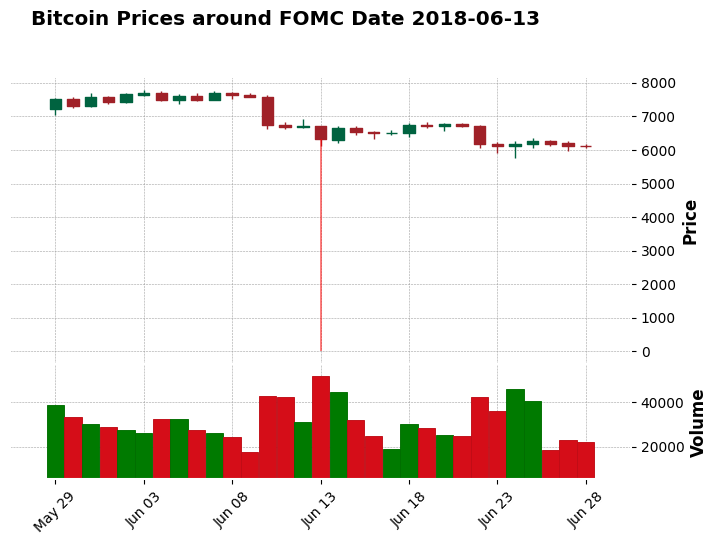

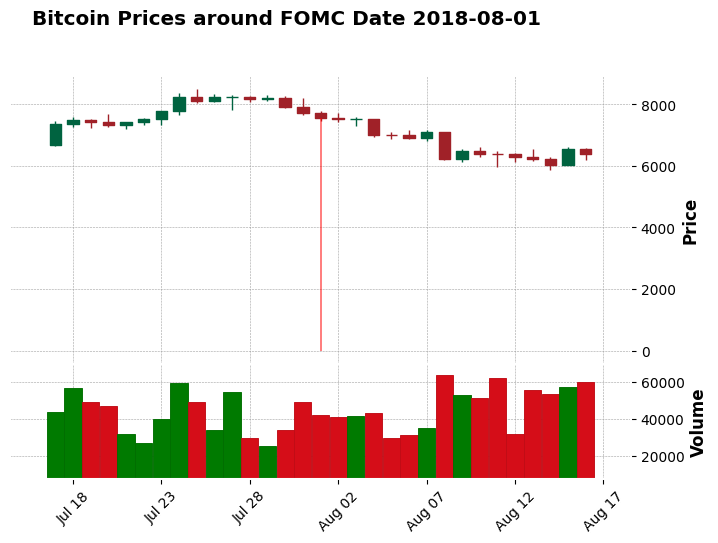

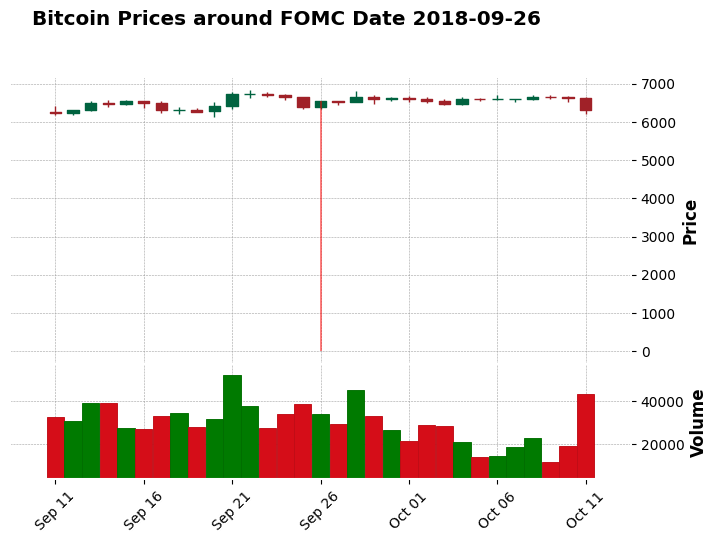

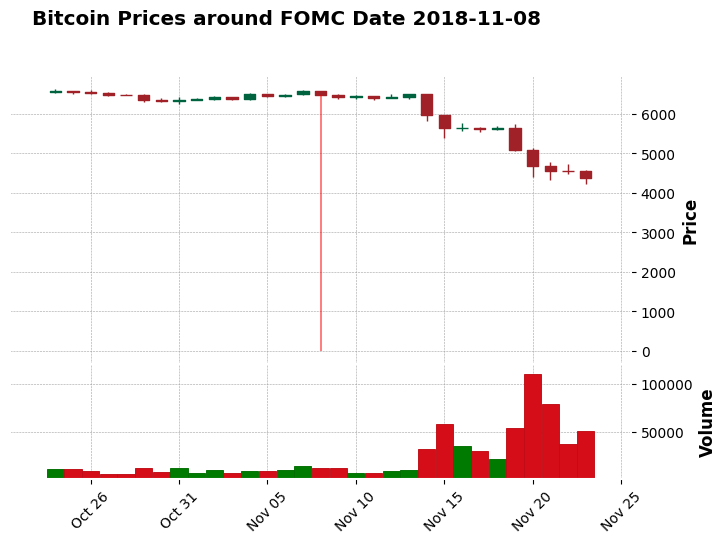

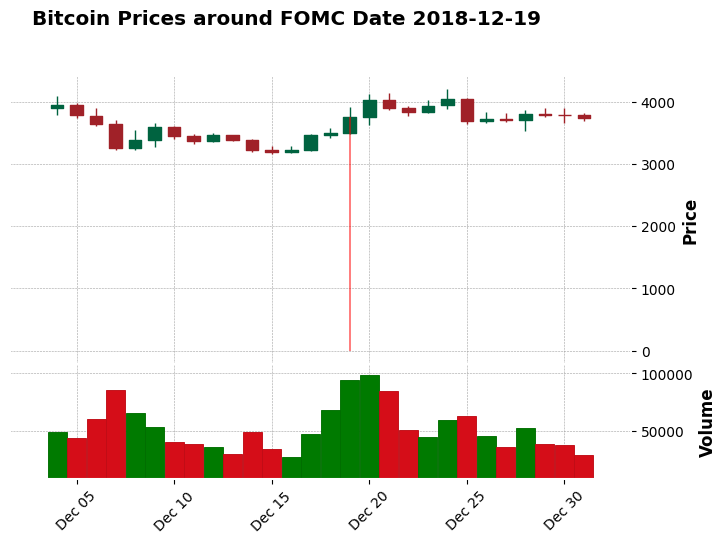

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_candlestick_chart_mpl(data, fomc_dates, year):
    # Ensure 'Date' is set as the index
    if 'Date' in data.columns:
        data = data.set_index('Date')
    data.index = pd.to_datetime(data.index)  # Convert the index to datetime

    # Iterate over each FOMC date
    for fomc_date in fomc_dates:
        # Check if FOMC date is in the specified year
        if fomc_date.year != year:
            continue

        # Create a 30-day period around the FOMC date
        start_date = fomc_date - pd.Timedelta(days=15)
        end_date = fomc_date + pd.Timedelta(days=15)

        # Filter data for the 30-day period
        period_data = data[(data.index >= start_date) & (data.index <= end_date)]

        # Skip if no data for the period
        if period_data.empty:
            continue

        # Get the price for the FOMC date to draw the line
        if fomc_date in period_data.index:
            fomc_price = period_data.loc[fomc_date, 'close']
        else:
            continue  # Skip if the FOMC date is not within the trading dates

        # Define the line as a tuple of two points (start and end)
        vline = [(fomc_date, 0), (fomc_date, fomc_price)]

        # Create a candlestick plot for the 30-day period
        mpf.plot(period_data[['open', 'high', 'low', 'close', 'volume']],
                 type='candle', style='charles',
                 title=f'Bitcoin Prices around FOMC Date {fomc_date.date()}',
                 figratio=(12, 8), volume=True, show_nontrading=True,
                 alines=dict(alines=[vline], colors=['red'], linewidths=1.2, alpha=0.5))

        # Show or save the plot as needed
        plt.show()  # or plt.savefig(f'chart_{fomc_date.date()}.png')

# Assuming df_2018 and fomc_2018_dates are already defined
plot_candlestick_chart_mpl(df_2018, fomc_2018_dates, 2018)


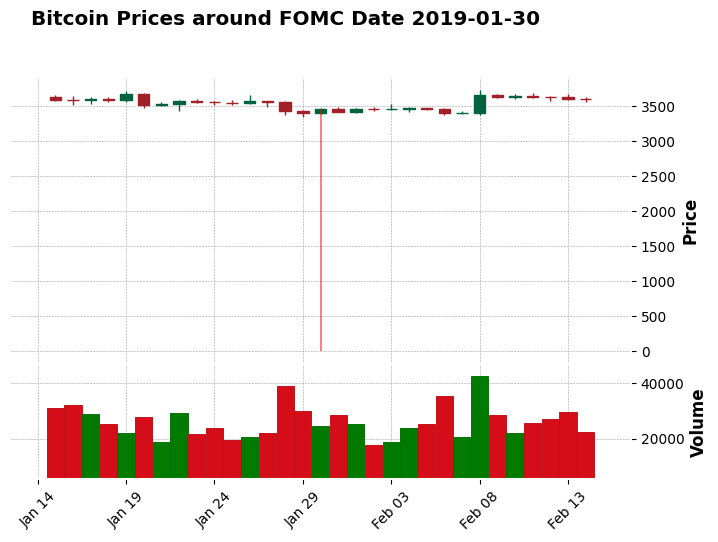

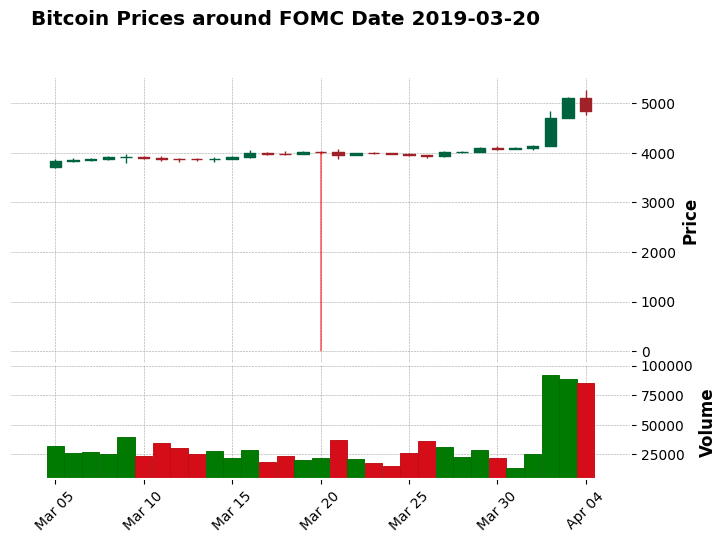

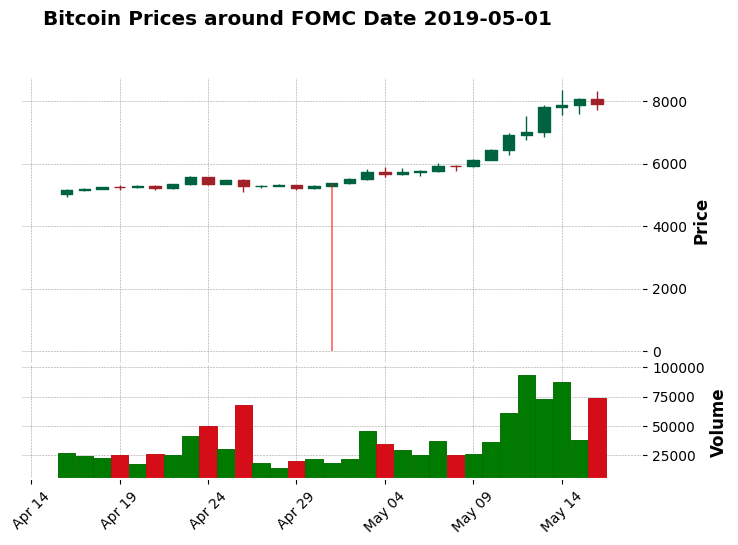

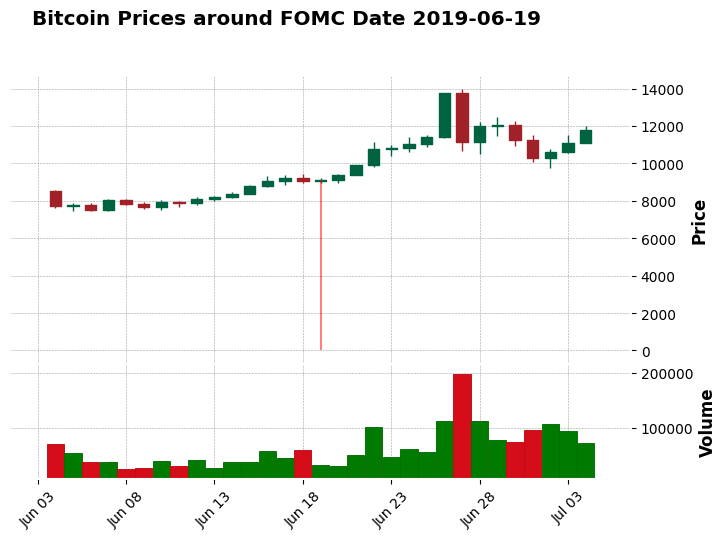

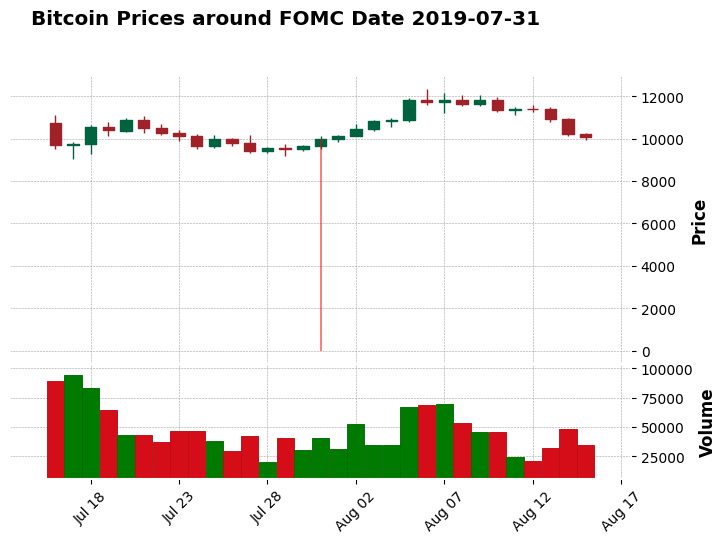

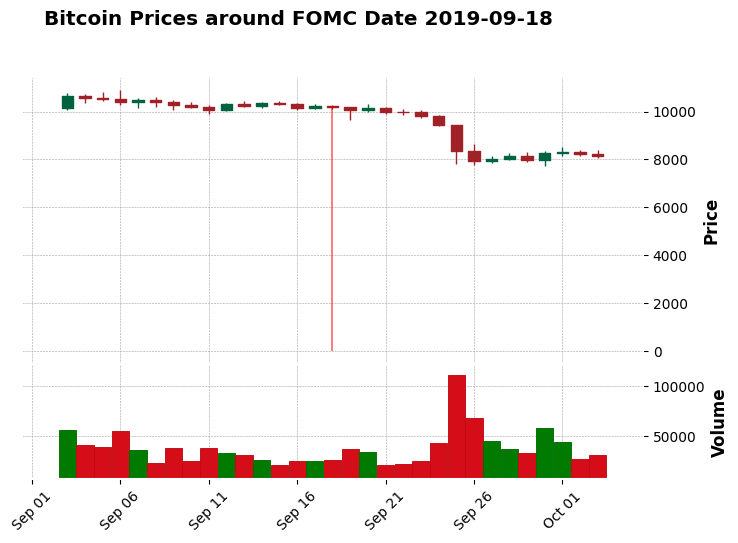

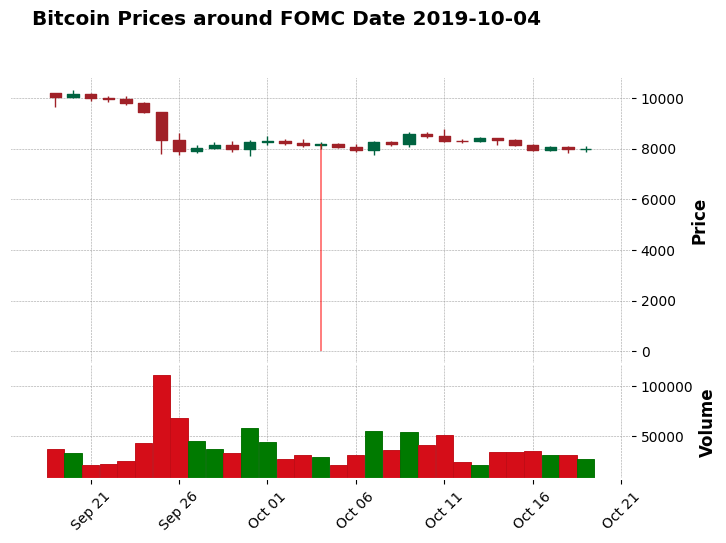

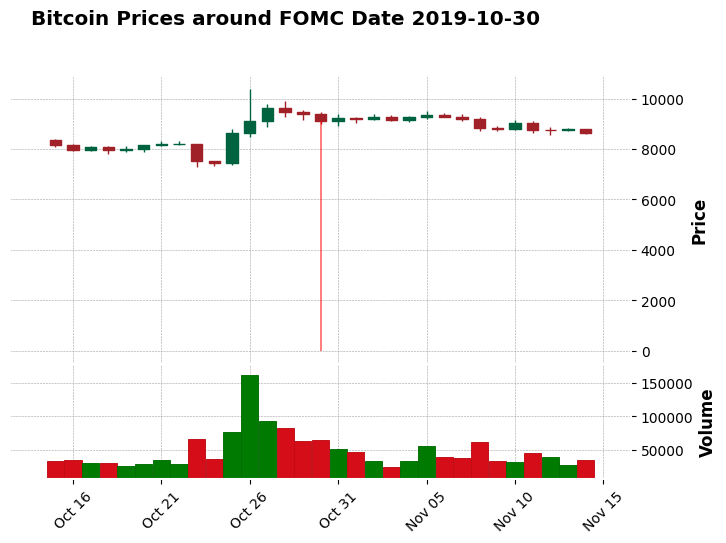

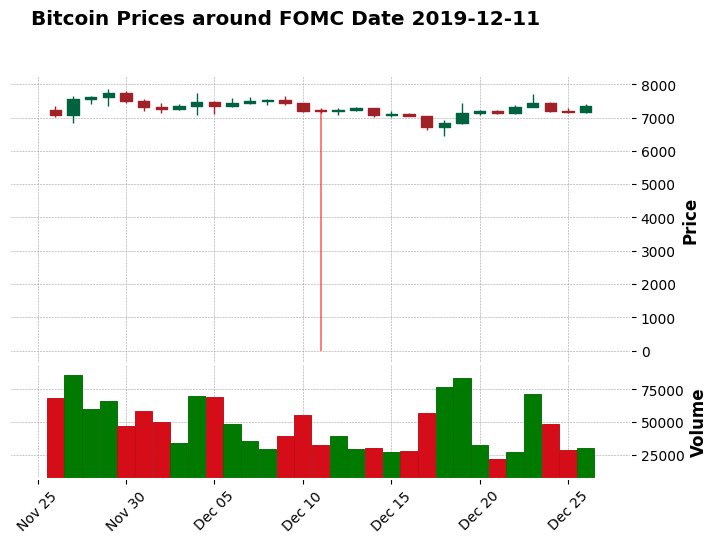

In [22]:
plot_candlestick_chart_mpl(df_2019, fomc_2019_dates, 2019)


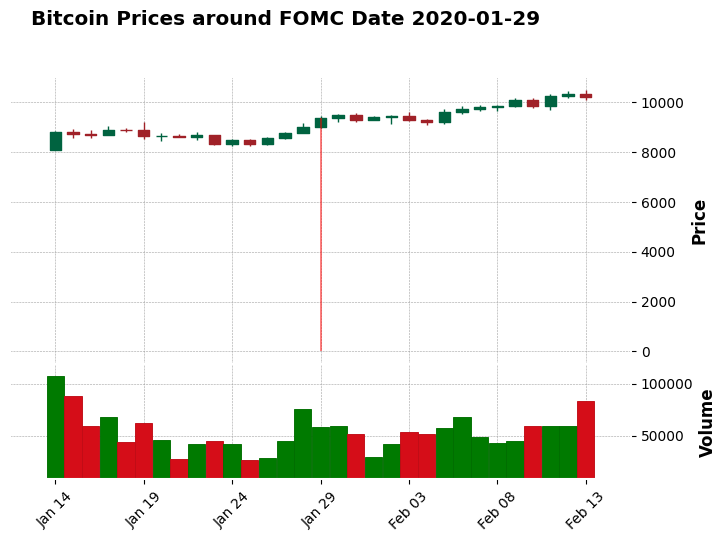

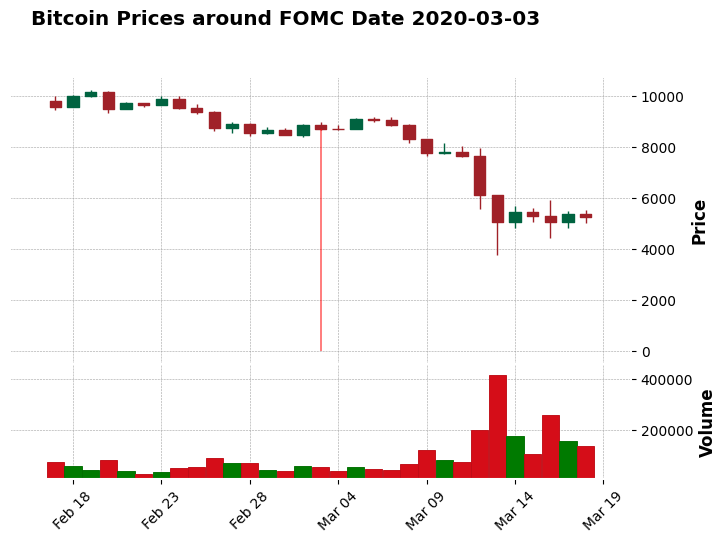

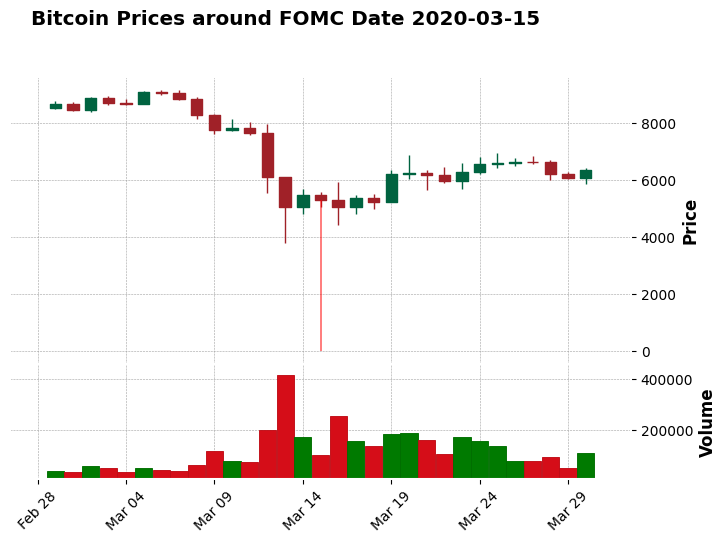

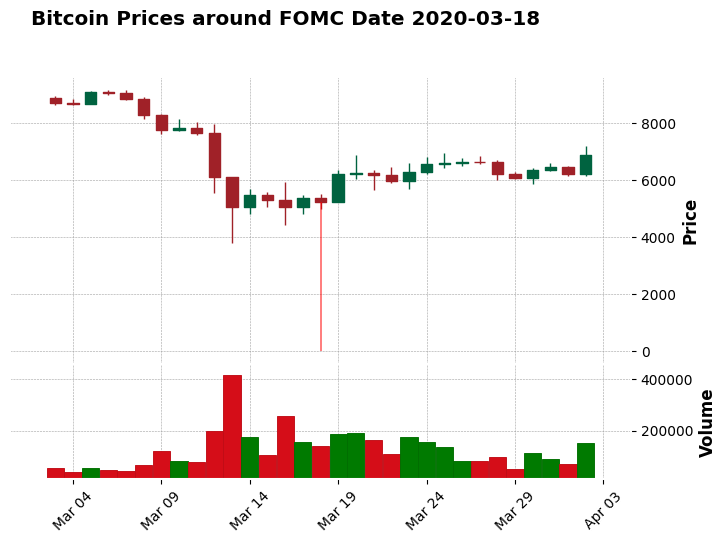

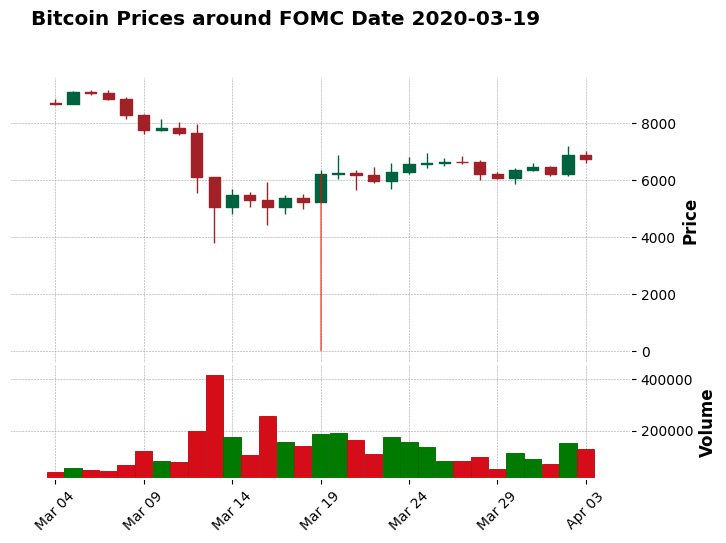

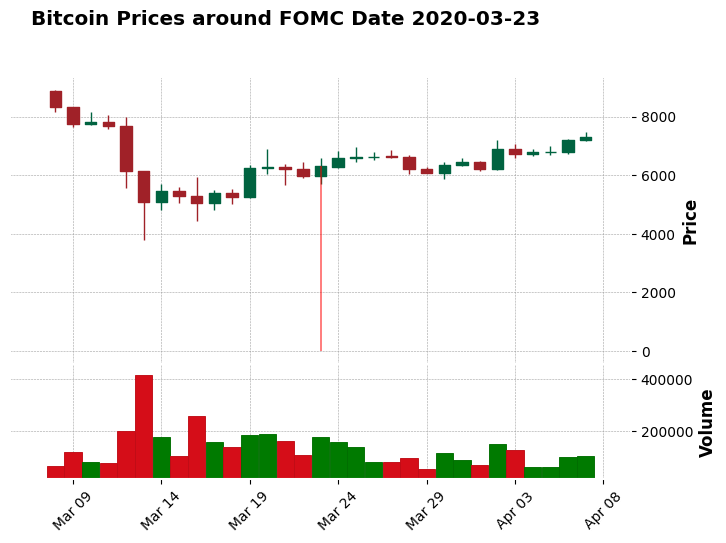

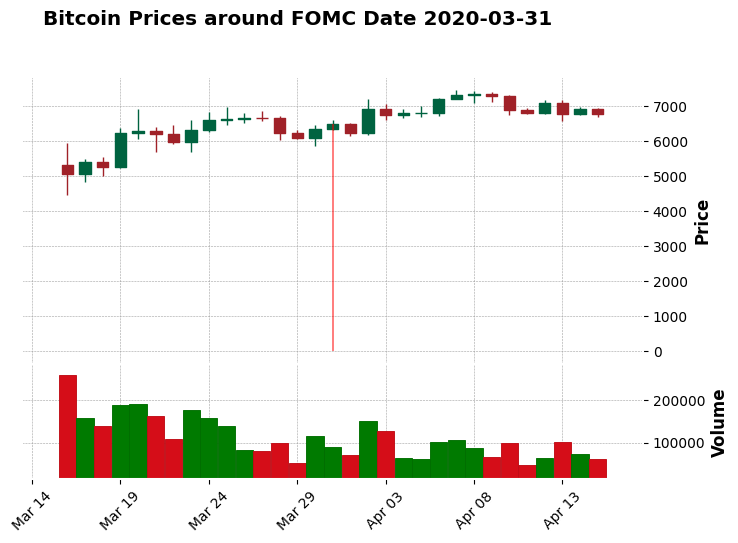

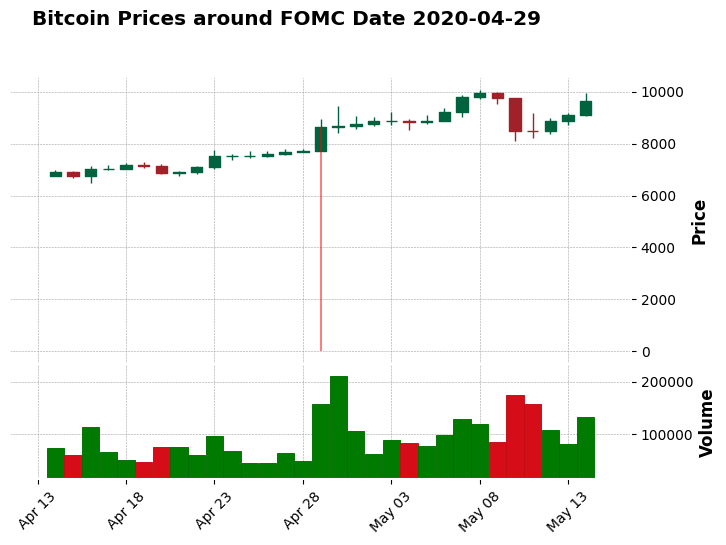

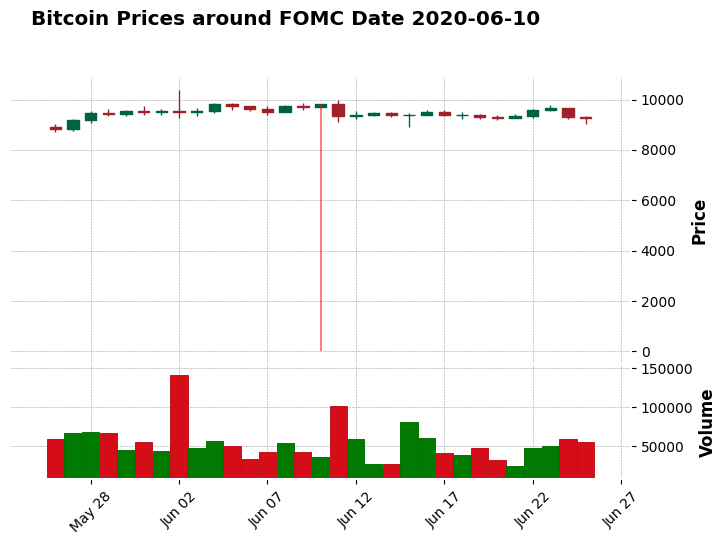

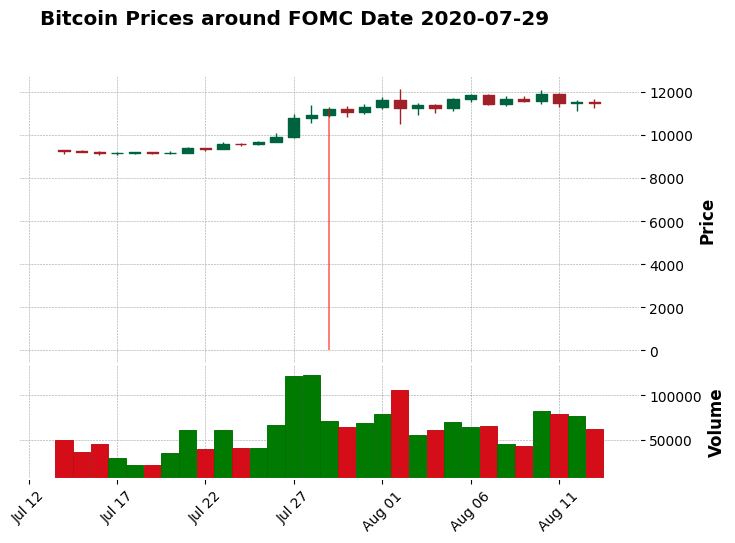

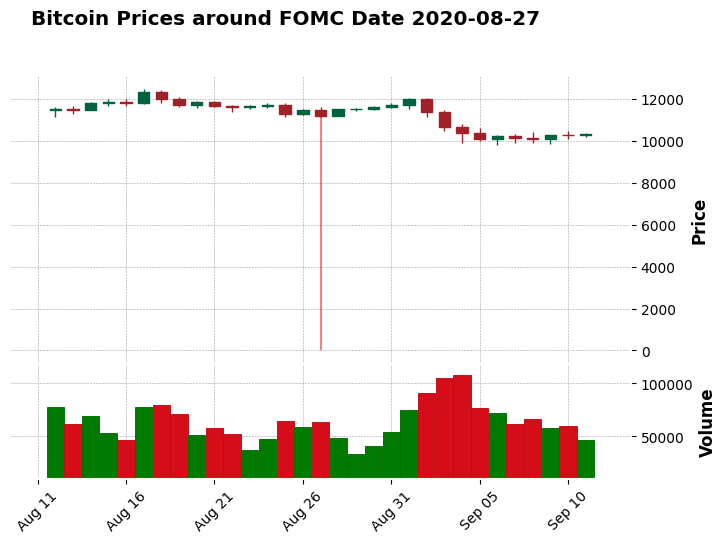

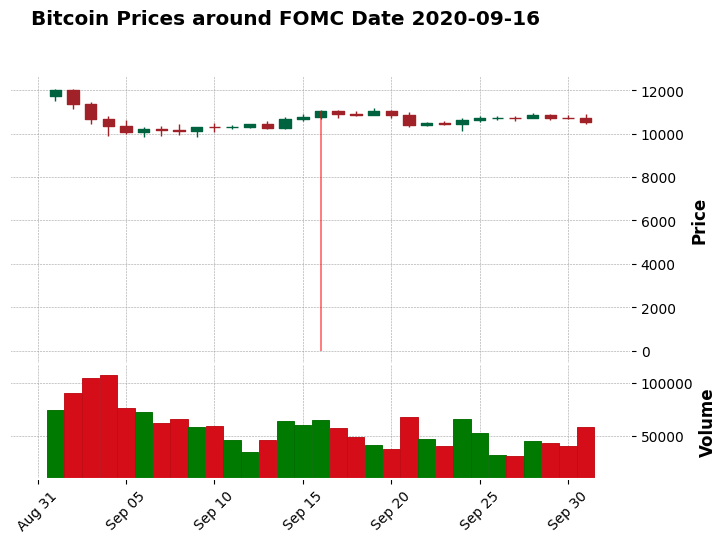

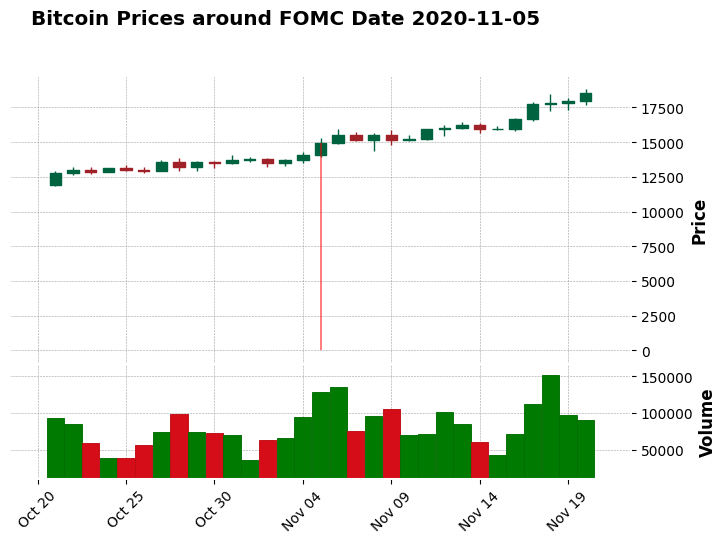

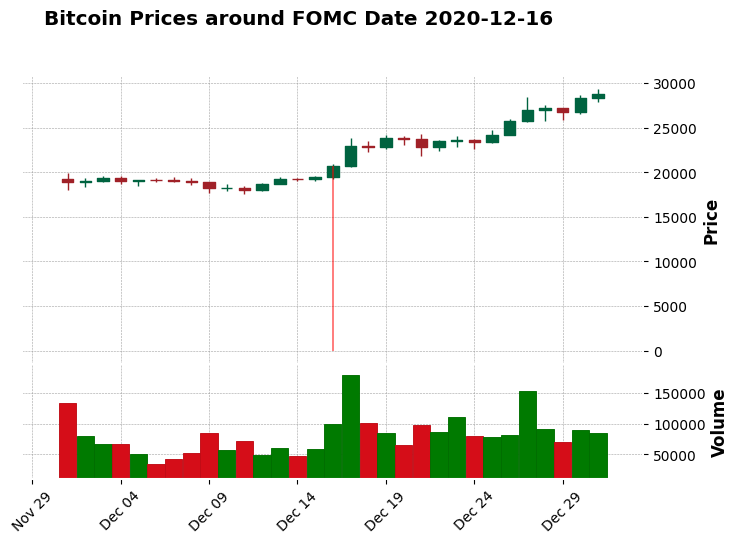

In [23]:
plot_candlestick_chart_mpl(df_2020, fomc_2020_dates, 2020)


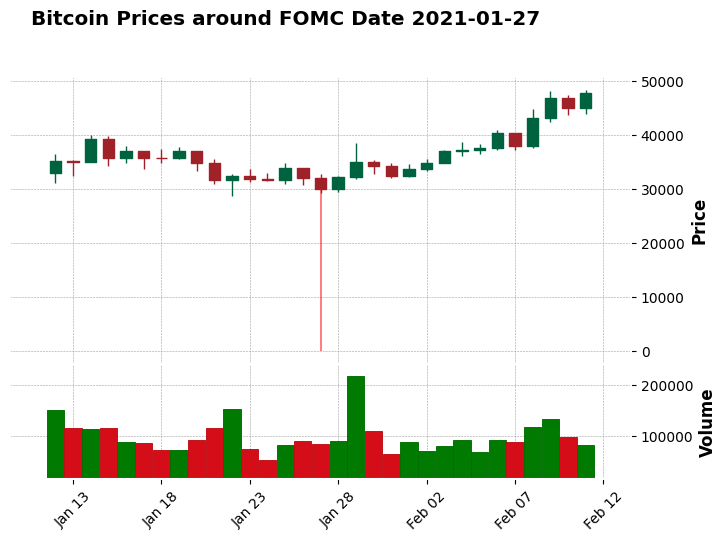

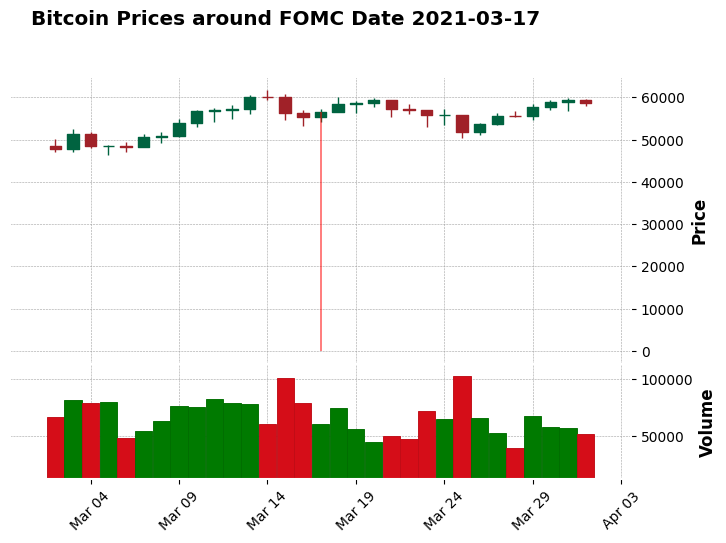

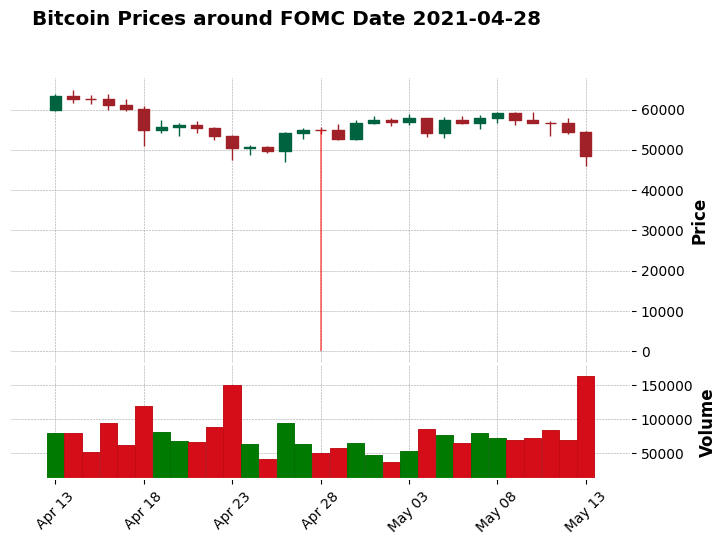

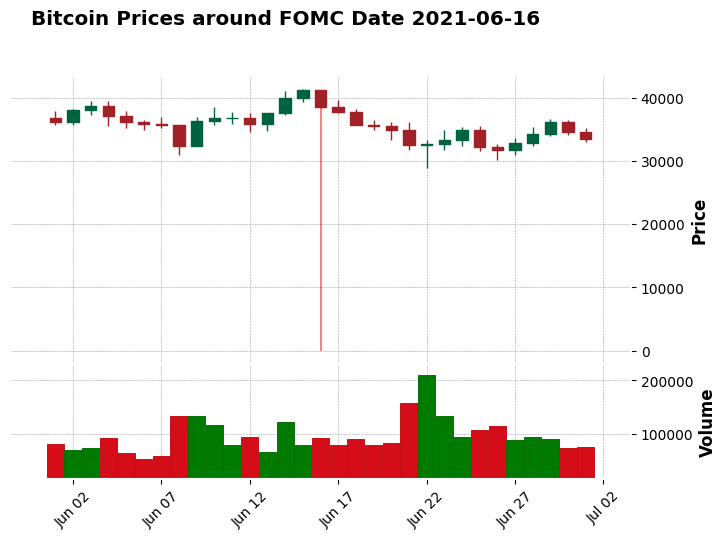

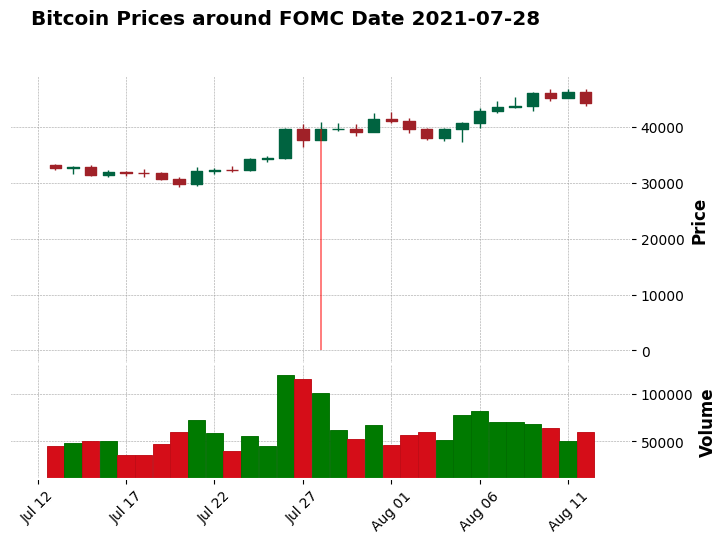

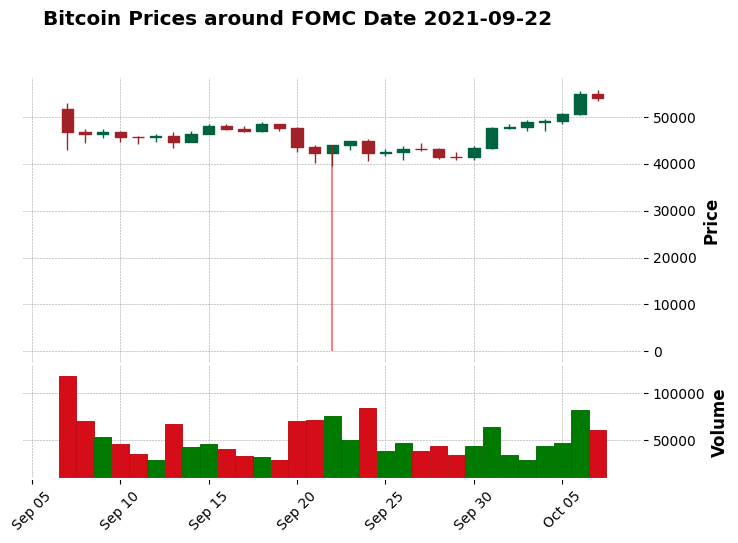

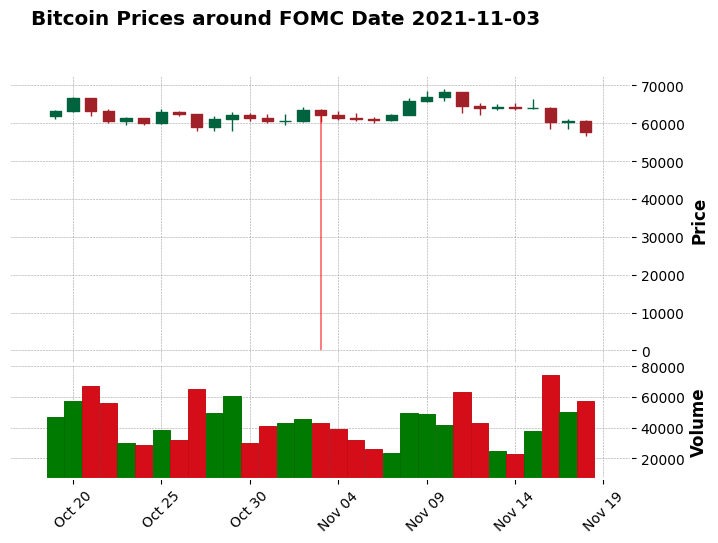

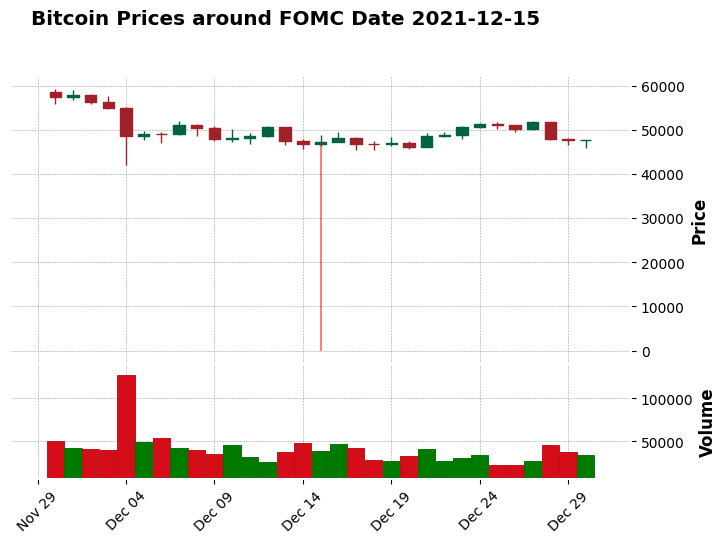

In [24]:
plot_candlestick_chart_mpl(df_2021, fomc_2021_dates, 2021)


#### Around the FOMC Dates the movement in price has not been much as we can infer from the above plots

# Fourier Analysis

The Fourier Transform, particularly its computational form, the Fast Fourier Transform (FFT), is a powerful tool in signal processing that decomposes a signal (like a Bitcoin price time series) into its constituent frequencies. This analysis is particularly useful in identifying periodic patterns, cycles, or trends in data.

Decomposing Time Series into Frequency Components:

Bitcoin price data over time is a time series that can be thought of as a signal. FFT transforms this time-based signal into a frequency-based one. It breaks down the entire series into components of different frequencies, allowing us to see if there are any dominant cycles in the data.

Identifying Dominant Frequencies:

FFT analysis reveals the main frequencies (cycles per unit time) present in the Bitcoin data. A high amplitude at a particular frequency indicates a strong presence of that cycle in the price movement. For instance, if there's a significant peak at a frequency corresponding to a 7-day cycle, it suggests a weekly pattern in Bitcoin prices.

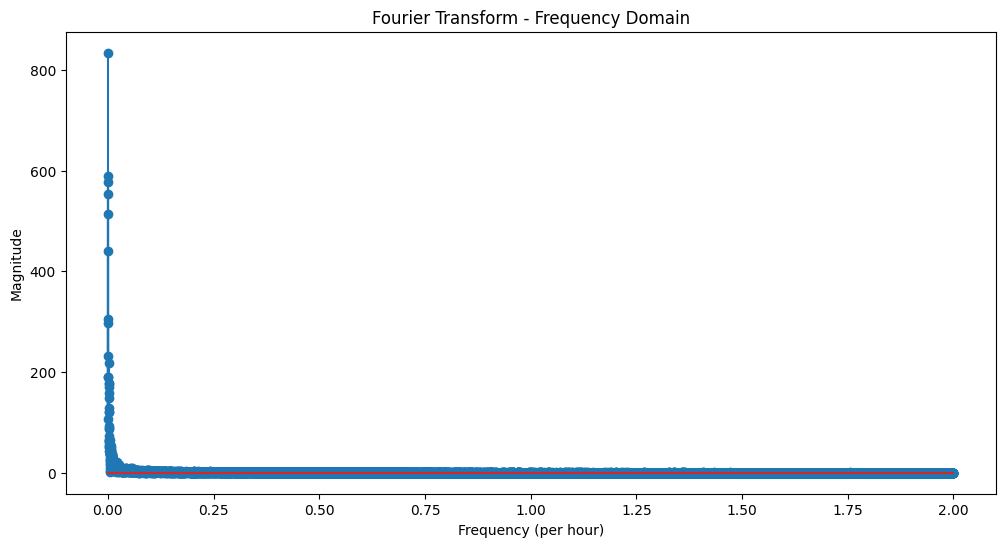

Dominant frequency: 0.00011508804235239959 per hour
Dominant period: 8689.0 hours
Dominant period: 362.0416666666667 days


In [ ]:
data = dfs[2018]['close']
data_array = data.values.astype(np.float64)

fft_result = fft(data_array)
frequencies = np.fft.fftfreq(len(fft_result), d=1/4)  
positive_frequencies = frequencies[frequencies > 0]
magnitudes = np.abs(fft_result[frequencies > 0]) / len(fft_result)

plt.figure(figsize=(12, 6))
plt.stem(positive_frequencies, magnitudes)
plt.title('Fourier Transform - Frequency Domain')
plt.xlabel('Frequency (per hour)')
plt.ylabel('Magnitude')
plt.show()

max_magnitude_idx = np.argmax(magnitudes)
dominant_frequency = positive_frequencies[max_magnitude_idx]
dominant_period_hours = 1 / dominant_frequency  
dominant_period_days = dominant_period_hours / 24 

print(f"Dominant frequency: {dominant_frequency} per hour")
print(f"Dominant period: {dominant_period_hours} hours")
print(f"Dominant period: {dominant_period_days} days")

In [ ]:
def perform_fourier_analysis_hr(data_series, sample_interval_hours):
    
    data_array = data_series.values.astype(np.float64)

    fft_result = fft(data_array)
    frequencies = np.fft.fftfreq(len(fft_result), d=sample_interval_hours)

    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_result[frequencies > 0]) / len(fft_result)

    # # Plot the spectrum
    # plt.figure(figsize=(12, 6))
    # plt.stem(positive_frequencies, magnitudes)
    # plt.title('Fourier Transform - Frequency Domain')
    # plt.xlabel('Frequency (per hour)')
    # plt.ylabel('Magnitude')
    # plt.show()

    max_magnitude_idx = np.argmax(magnitudes)
    dominant_frequency = positive_frequencies[max_magnitude_idx]
    dominant_period_hours = 1 / dominant_frequency  
    dominant_period_days = dominant_period_hours / 24  
    print(f"Dominant frequency: {dominant_frequency} per hour")
    print(f"Dominant period: {dominant_period_hours} hours")
    print(f"Dominant period: {dominant_period_days} days")

    return dominant_frequency, dominant_period_days

# Example usage with your data
data_2019 = dfs[2019]['close']  #
dominant_freq, dominant_period = perform_fourier_analysis_hr(data_2019, 1/4)


Dominant frequency: 0.0001145376972195974 per hour
Dominant period: 8730.75 hours
Dominant period: 363.78125 days


In [ ]:
def perform_fourier_analysis(data_series, sample_interval_minutes):

    data_array = data_series.values.astype(np.float64)

    # Apply FFT
    fft_result = fft(data_array)
    frequencies = np.fft.fftfreq(len(fft_result), d=sample_interval_minutes / 60)

    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_result[frequencies > 0]) / len(fft_result)

    # plt.figure(figsize=(12, 6))
    # plt.stem(positive_frequencies, magnitudes)
    # plt.title('Fourier Transform - Frequency Domain')
    # plt.xlabel('Frequency (per min)')
    # plt.ylabel('Magnitude')
    # plt.show()
    max_magnitude_idx = np.argmax(magnitudes)
    dominant_frequency = positive_frequencies[max_magnitude_idx]
    dominant_period_minutes = 1 / dominant_frequency  

    print(f"Dominant frequency: {dominant_frequency} per minute")
    print(f"Dominant period: {dominant_period_minutes} minutes")
    print(f"Dominant period: {dominant_period_days} days")

    return dominant_frequency, dominant_period_days


In [ ]:
data_2018 = dfs[2018]['close']
dominant_freq, dominant_period = perform_fourier_analysis(data_2018, 15)
data_2019 = dfs[2019]['close']  
dominant_freq, dominant_period = perform_fourier_analysis(data_2019, 15)
data_2020 = dfs[2020]['close']
dominant_freq, dominant_period = perform_fourier_analysis(data_2020, 15)
data_2021 = dfs[2021]['close']  
dominant_freq, dominant_period = perform_fourier_analysis(data_2021, 15)  
data_2022 = dfs[2022]['close']  
dominant_freq, dominant_period = perform_fourier_analysis(data_2022, 15)

#### Potential Weekly Pattern
The dominant period is the length of time over which the most significant pattern or cycle in the data repeats itself

#### Low Frequency
A low frequency implies that the most significant fluctuations in the Bitcoin price do not happen very often. The predominant changes or patterns in the data occur over longer time intervals rather than in rapid succession.

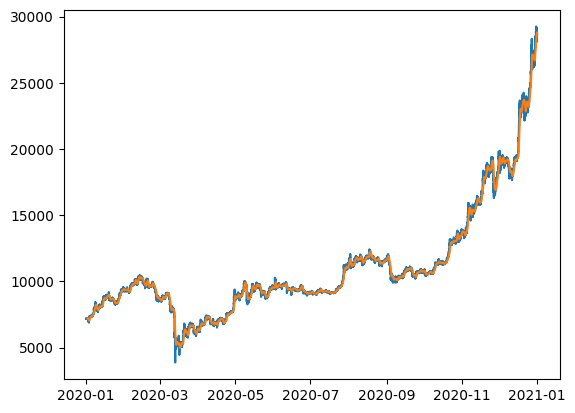

In [ ]:
plt.plot(dfs[2020]['Date'],dfs[2020]['close'])
plt.plot(dfs[2020]['Date'],dfs[2020]['close'].rolling(window=100).mean())

In [ ]:
data_2021 = dfs[2021]['close']  
dominant_freq, dominant_period = perform_fourier_analysis(data_2021, 1/4)


Dominant frequency: 0.0137240886347391 per minute
Dominant period: 72.86458333333333 minutes
Dominant period: 362.0416666666667 days


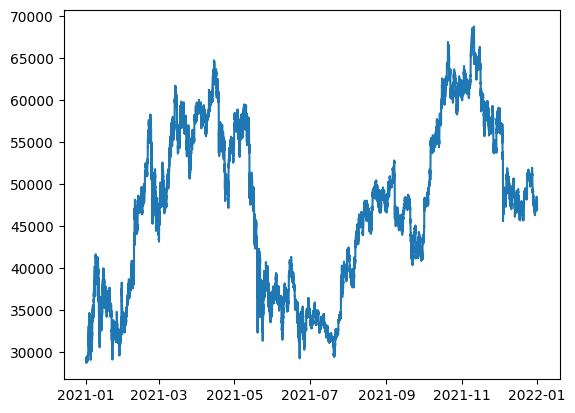

In [ ]:
plt.plot(dfs[2021]['Date'],dfs[2021]['close'])

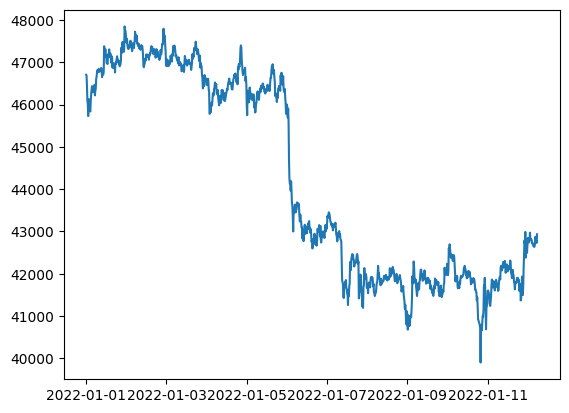

In [ ]:
plt.plot(dfs[2022]['Date'],dfs[2022]['close'])

In [ ]:
data_2022 = dfs[2022]['close']  # Assuming dfs[2019] is your DataFrame for the year 2019
dominant_freq, dominant_period = perform_fourier_analysis(data_2022, 1/4)


Dominant frequency: 0.22242817423540315 per minute
Dominant period: 4.495833333333334 minutes
Dominant period: 362.0416666666667 days


### Dominant Frequency: 
The dominant frequency is approximately 0.0037 per hour. This value represents the most prominent cyclic pattern in your dataset when measured in terms of frequency. A frequency in this context refers to how often a particular pattern or cycle repeats itself over time.


### Dominant Period in Hours (269.75 hours):  
The dominant period, which is the inverse of the dominant frequency, is about 269.75 hours. This value indicates the length of time it takes for the most significant cyclic pattern in your data to complete one full cycle. In simpler terms, it's the time duration between the repeating patterns or trends in your 'close' price data.

### Dominant Period in Days (approximately 11.24 days):  
When converted into days, the dominant period is around 11.24 days. This conversion makes the interpretation more intuitive in the context of daily or weekly cycles. It suggests that the most prominent cycle or pattern in your data repeats roughly every 11 days.

In [ ]:
dfs[2018]['Date'] = pd.to_datetime(dfs[2018]['Date'])
dfs[2018]['Month'] = dfs[2018]['Date'].dt.month

dfsm = {}

for month in dfs[2018]['Month'].unique():
    dfsm[month] = dfs[2018][dfs[2018]['Month'] == month]

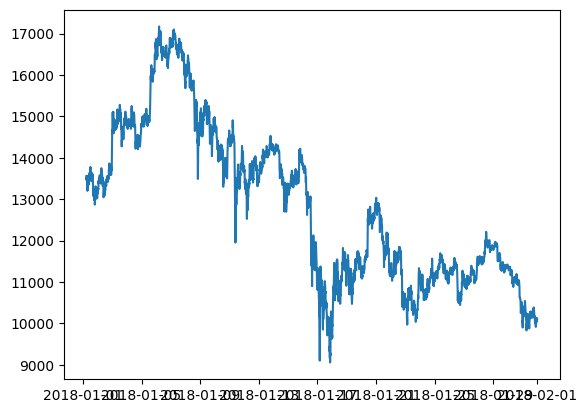

In [ ]:
plt.plot(dfsm[1]['Date'],dfsm[1]['close'])

In [ ]:
for i in range(1,12):
    dominant_freq, dominant_period = perform_fourier_analysis(dfsm[i]['close'], 1/4)

Dominant frequency: 0.08143875127248049 per minute
Dominant period: 12.279166666666667 minutes
Dominant period: 362.0416666666667 days
Dominant frequency: 0.09404388714733543 per minute
Dominant period: 10.633333333333333 minutes
Dominant period: 362.0416666666667 days
Dominant frequency: 0.08064516129032258 per minute
Dominant period: 12.4 minutes
Dominant period: 362.0416666666667 days
Dominant frequency: 0.08333333333333333 per minute
Dominant period: 12.0 minutes
Dominant period: 362.0416666666667 days
Dominant frequency: 0.08064516129032258 per minute
Dominant period: 12.4 minutes
Dominant period: 362.0416666666667 days
Dominant frequency: 0.08471584892340275 per minute
Dominant period: 11.804166666666667 minutes
Dominant period: 362.0416666666667 days
Dominant frequency: 0.0814663951120163 per minute
Dominant period: 12.275 minutes
Dominant period: 362.0416666666667 days
Dominant frequency: 0.08064516129032258 per minute
Dominant period: 12.4 minutes
Dominant period: 362.04166666

In [ ]:
data_2018_2 = dfsm[2]['close']  # Assuming dfs[2019] is your DataFrame for the year 2019
dominant_freq, dominant_period = perform_fourier_analysis(data_2018_2, 1/4)


Dominant frequency: 0.09404388714733543 per minute
Dominant period: 10.633333333333333 minutes
Dominant period: 362.0416666666667 days


In [ ]:
data_2018_3 = dfsm[3]['close']  # Assuming dfs[2019] is your DataFrame for the year 2019
dominant_freq, dominant_period = perform_fourier_analysis(data_2018_3, 1/4)


Dominant frequency: 0.08064516129032258 per minute
Dominant period: 12.4 minutes
Dominant period: 362.0416666666667 days


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


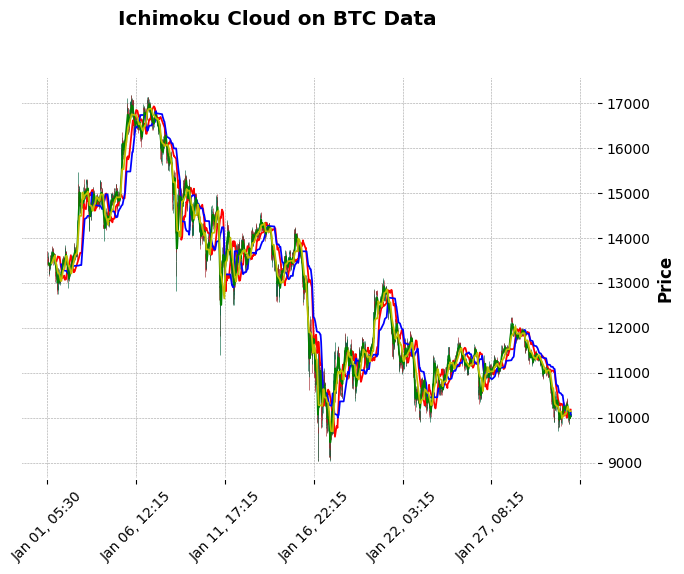

In [ ]:
btc_data=dfsm[1].copy()
btc_data.set_index('Date', inplace=True)

# Calculating Ichimoku components
btc_data['tenkan_sen'] = (btc_data['high'].rolling(window=9).max() + btc_data['low'].rolling(window=9).min()) / 2
btc_data['kijun_sen'] = (btc_data['high'].rolling(window=26).max() + btc_data['low'].rolling(window=26).min()) / 2
btc_data['senkou_span_a'] = ((btc_data['tenkan_sen'] + btc_data['kijun_sen']) / 2).shift(26)
btc_data['senkou_span_b'] = ((btc_data['high'].rolling(window=52).max() + btc_data['low'].rolling(window=52).min()) / 2).shift(26)

# Plotting
add_plot = [
    mpf.make_addplot(btc_data['senkou_span_a'], color='r'),
    mpf.make_addplot(btc_data['senkou_span_b'], color='b'),
    mpf.make_addplot(btc_data['tenkan_sen'], color='g'),
    mpf.make_addplot(btc_data['kijun_sen'], color='y'),
]

mpf.plot(btc_data, type='candle', addplot=add_plot, title="Ichimoku Cloud on BTC Data", style='charles')

# Hilbert Transforms

In [ ]:
# Function to calculate Hilbert Transform Dominant Cycle Period
def calculate_ht_dcperiod(data):
    analytic_signal = hilbert(data['close'])
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))

    dcperiod = np.zeros_like(instantaneous_phase)
    for i in range(1, len(instantaneous_phase)):
        dcperiod[i] = i - np.argmin(instantaneous_phase[:i])
        if dcperiod[i] > 1.5 * dcperiod[i - 1]:
            dcperiod[i] = dcperiod[i - 1]

    return dcperiod


def calculate_ht_dcperiod_improved(data):
    analytic_signal = hilbert(data['close'])
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))

    # Instead of using the raw phase to find the cycle period,
    # we calculate the period by finding the time difference between similar phases.
    dcperiod = np.full_like(instantaneous_phase, np.nan)  # Initialized with NaN
    prev_phase_idx = {}
    
    for i, phase in enumerate(instantaneous_phase):
        # Round the phase to reduce sensitivity to minor phase changes
        rounded_phase = round(phase, 2)
        
        if rounded_phase in prev_phase_idx:
            # Calculate the period
            period = i - prev_phase_idx[rounded_phase]
            dcperiod[i] = period

            # Update the last index for this phase
            prev_phase_idx[rounded_phase] = i
        else:
            # Record the first occurrence of this phase
            prev_phase_idx[rounded_phase] = i

    return dcperiod

# Function to calculate Hilbert Transform Dominant Cycle Phase
def calculate_ht_dcphase(data):
    analytic_signal = hilbert(data['close'])
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    return np.rad2deg(instantaneous_phase)

# Function to calculate Hilbert Transform Trend vs Cycle Mode
def calculate_ht_trendmode(data, dcperiod):
    trendmode = np.zeros_like(data['close'])
    for i in range(len(dcperiod)):
        if i < 6:
            trendmode[i] = np.nan
        else:
            s = data['close'][i - int(dcperiod[i]):i]
            if len(s) < 3:
                trendmode[i] = 0
            else:
                F = np.polyfit(range(len(s)), s, 1)[0]
                trendmode[i] = 1 if abs(F) > 0.01 else 0
    return trendmode

def calculate_ht_trendmode_improved(data, dcperiod):
    trendmode = np.zeros_like(data['close'])

    for i in range(len(dcperiod)):
        # Check if dcperiod is NaN or less than 3, which is not sufficient for trend calculation
        if np.isnan(dcperiod[i]) or dcperiod[i] < 3:
            trendmode[i] = np.nan
        else:
            try:
                # Ensure the index is an integer and within the bounds of the data
                period_start = max(i - int(dcperiod[i]), 0)
                s = data['close'][period_start:i]

                if len(s) < 3:
                    trendmode[i] = np.nan
                else:
                    # Linear trend fitting
                    F = np.polyfit(range(len(s)), s, 1)[0]
                    trendmode[i] = 1 if abs(F) > 0.01 else 0
            except Exception as e:
                # Handle any other unexpected exceptions
                trendmode[i] = np.nan

    return trendmode



In [ ]:
# Calculate HT DCPERIOD, DCPHASE, and TRENDMODE for the data
df['HT_DCPERIOD'] = calculate_ht_dcperiod_improved(df)
df['HT_DCPHASE'] = calculate_ht_dcphase(df)
df['HT_TRENDMODE'] = calculate_ht_trendmode_improved(df, df['HT_DCPERIOD'])


In [ ]:
# Plotting the results
plt.figure(figsize=(15, 10))

# Plot Dominant Cycle Period
plt.subplot(4, 1, 1)
plt.plot(df3.index, df3['HT_DCPERIOD'], label='HT DCPERIOD')
plt.title('Hilbert Transform - Dominant Cycle Period')
plt.xlabel('Date')
plt.ylabel('DCPERIOD')
plt.legend()

# Plot Dominant Cycle Phase
plt.subplot(4, 1, 2)
plt.plot(df.index, df['HT_DCPHASE'], label='HT DCPHASE', color='orange')
plt.title('Hilbert Transform - Dominant Cycle Phase')
plt.xlabel('Date')
plt.ylabel('DCPHASE')
plt.legend()

# Plot Close
plt.subplot(4, 1, 3)
plt.plot(df.index, df['close'], label='close', color='blue')
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()


# Plot Trend vs Cycle Mode
plt.subplot(4, 1, 4)
plt.plot(df.index, df['HT_TRENDMODE'], label='HT TRENDMODE', color='green')
plt.title('Hilbert Transform - Trend vs Cycle Mode')
plt.xlabel('Date')
plt.ylabel('TRENDMODE')
plt.legend()

plt.tight_layout()
plt.show()

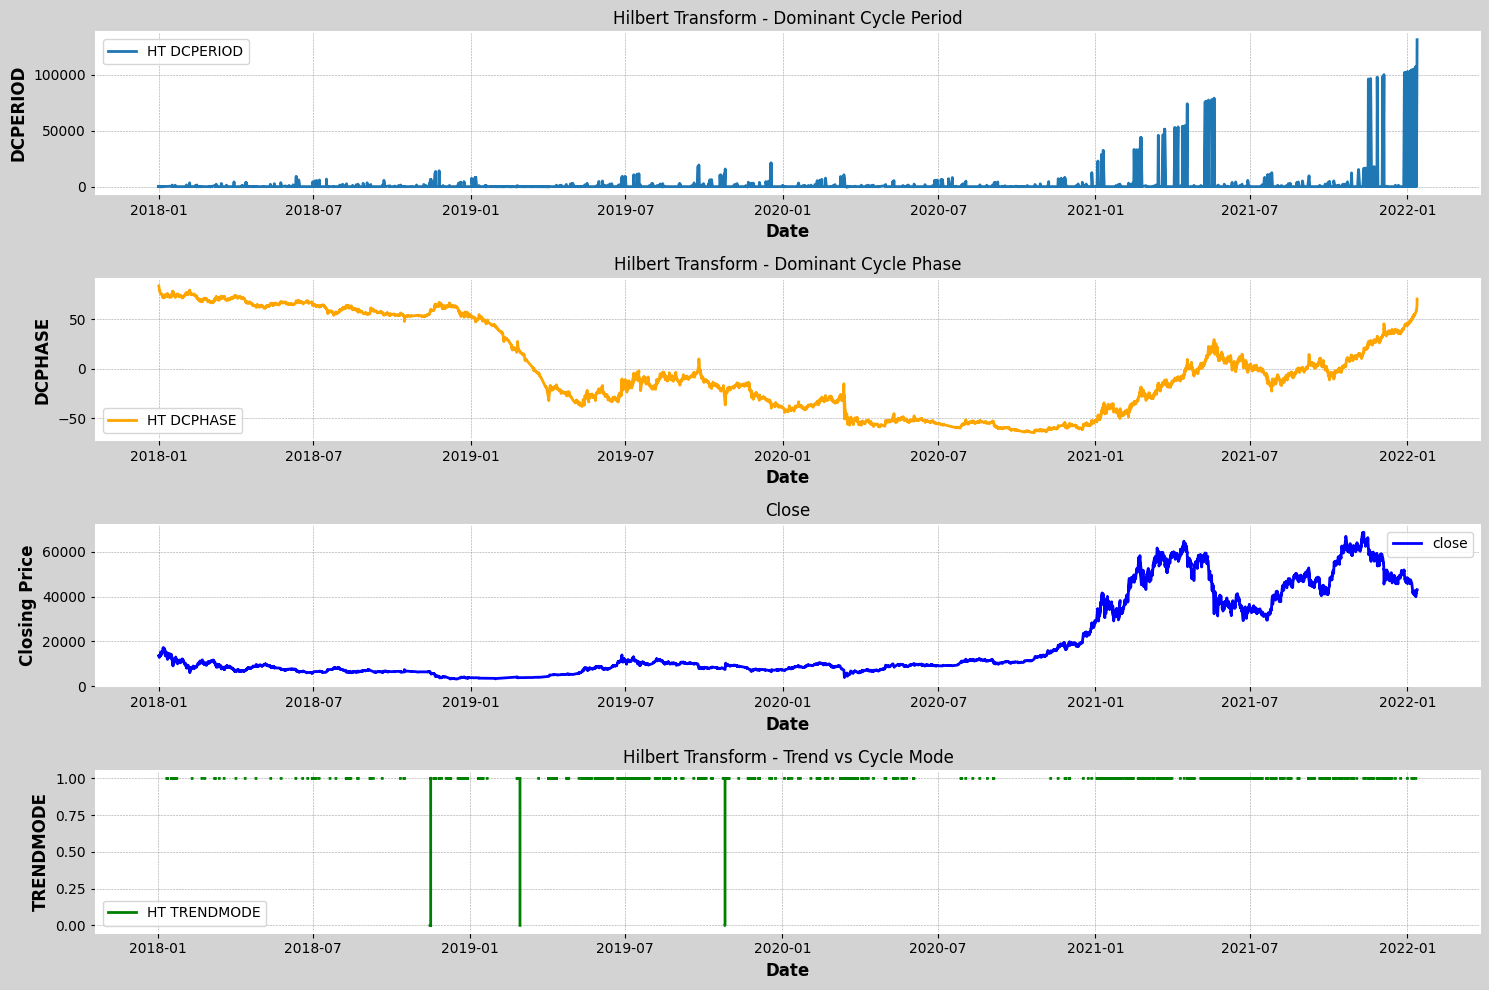

In [ ]:
# Plotting the results
plt.figure(figsize=(15, 10))

# Plot Dominant Cycle Period
plt.subplot(4, 1, 1)
plt.plot(df.index, df['HT_DCPERIOD'], label='HT DCPERIOD')
plt.title('Hilbert Transform - Dominant Cycle Period')
plt.xlabel('Date')
plt.ylabel('DCPERIOD')
plt.legend()

# Plot Dominant Cycle Phase
plt.subplot(4, 1, 2)
plt.plot(df.index, df['HT_DCPHASE'], label='HT DCPHASE', color='orange')
plt.title('Hilbert Transform - Dominant Cycle Phase')
plt.xlabel('Date')
plt.ylabel('DCPHASE')
plt.legend()

# Plot Close
plt.subplot(4, 1, 3)
plt.plot(df.index, df['close'], label='close', color='blue')
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()


# Plot Trend vs Cycle Mode
plt.subplot(4, 1, 4)
plt.plot(df.index, df['HT_TRENDMODE'], label='HT TRENDMODE', color='green')
plt.title('Hilbert Transform - Trend vs Cycle Mode')
plt.xlabel('Date')
plt.ylabel('TRENDMODE')
plt.legend()

plt.tight_layout()
plt.show()

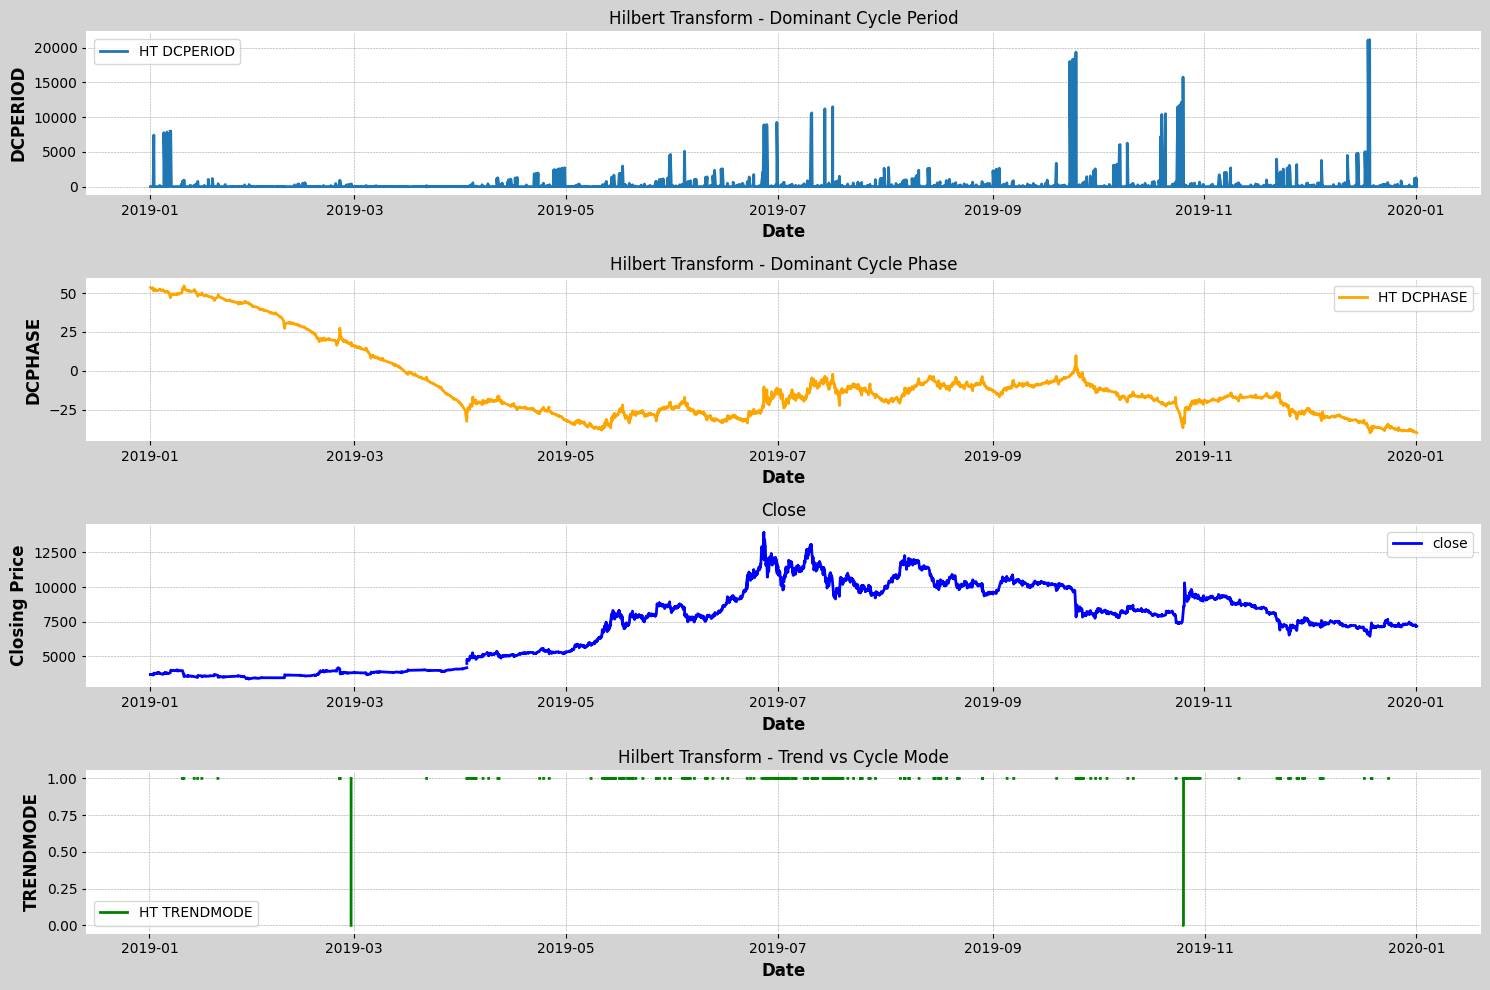

In [ ]:
# Plotting the results
plt.figure(figsize=(15, 10))

# Plot Dominant Cycle Period
plt.subplot(4, 1, 1)
plt.plot(df3.index, df3['HT_DCPERIOD'], label='HT DCPERIOD')
plt.title('Hilbert Transform - Dominant Cycle Period')
plt.xlabel('Date')
plt.ylabel('DCPERIOD')
plt.legend()

# Plot Dominant Cycle Phase
plt.subplot(4, 1, 2)
plt.plot(df3.index, df3['HT_DCPHASE'], label='HT DCPHASE', color='orange')
plt.title('Hilbert Transform - Dominant Cycle Phase')
plt.xlabel('Date')
plt.ylabel('DCPHASE')
plt.legend()

# Plot Close
plt.subplot(4, 1, 3)
plt.plot(df3.index, df3['close'], label='close', color='blue')
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()


# Plot Trend vs Cycle Mode
plt.subplot(4, 1, 4)
plt.plot(df3.index, df3['HT_TRENDMODE'], label='HT TRENDMODE', color='green')
plt.title('Hilbert Transform - Trend vs Cycle Mode')
plt.xlabel('Date')
plt.ylabel('TRENDMODE')
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_62691/893252444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_return'] = np.log(df['close']).diff()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as

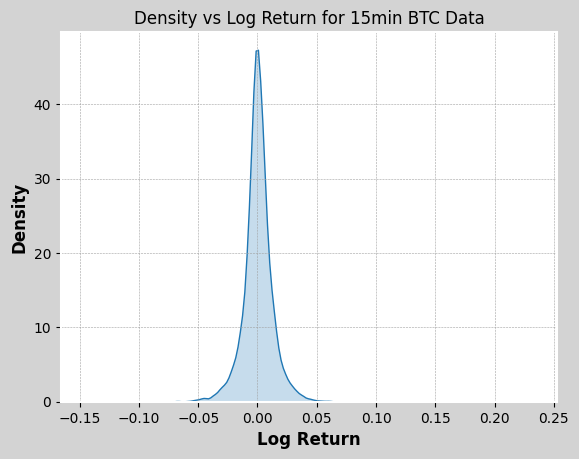

In [ ]:
df['log_return'] = np.log(df['close']).diff()

# Drop NaN values that result from the diff() calculation
df = df.dropna()

# Plotting the density vs log return
sns.kdeplot(df['log_return'], fill=True)
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Density vs Log Return for 15min BTC Data')
plt.show()

#### During the beginning of a cycle phase (near 0 or 360 degrees in HT_DCPHASE), one might anticipate a new trend starting and look for entry points in the direction of the expected trend.
### At the midpoint of a cycle (around 180 degrees in HT_DCPHASE), one might be cautious of potential pullbacks or reversals.

In [ ]:
df.set_index('Date',inplace=True)
column_data = df[['HT_DCPERIOD','HT_DCPHASE','HT_TRENDMODE']]

# Write the DataFrame to an Excel file
column_data.to_excel('output.xlsx', index=False)
df3=df['2019-01-01 05:30:00':'2020-01-01 05:30:00'].copy()

# Volatility Analysis

In [ ]:
df.set_index('Date', inplace=True)

daily_highs = df['high'].resample('D').max()
daily_lows = df['low'].resample('D').min()
daily_range = daily_highs - daily_lows

daily_closes = df['close'].resample('D').last()
daily_pct_change = daily_closes.pct_change()


high_volatility_threshold = daily_range.quantile(0.75)
high_volatility_days = daily_range[daily_range > high_volatility_threshold]


In [ ]:
df_sample = df.loc['2021-01-01':'2022-12-31']

# Calculating daily highs, lows, ranges, and percent changes
daily_highs = df_sample['high'].resample('D').max()
daily_lows = df_sample['low'].resample('D').min()
daily_range = daily_highs - daily_lows
daily_closes = df_sample['close'].resample('D').last()
daily_pct_change = daily_closes.pct_change()

# Calculating the high volatility threshold
high_volatility_threshold = daily_range.quantile(0.75)
high_volatility_days = daily_range[daily_range > high_volatility_threshold]

# Filter the dataframe for the year 2021-2022 to check the volatility
volatility_2021_2022 = high_volatility_days.loc['2021':'2022']

# Output some of the results
volatility_2021_2022.head()

/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_94980/403130351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample2['Return'] = df_sample2['close'].pct_change()
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_94980/403130351.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample2['Rolling_Mean'] = (df_sample2['Return'].rolling(window=rolling_window).mean())*100
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_94980/403130351.py:9: SettingWithCopyWarning: 
A 

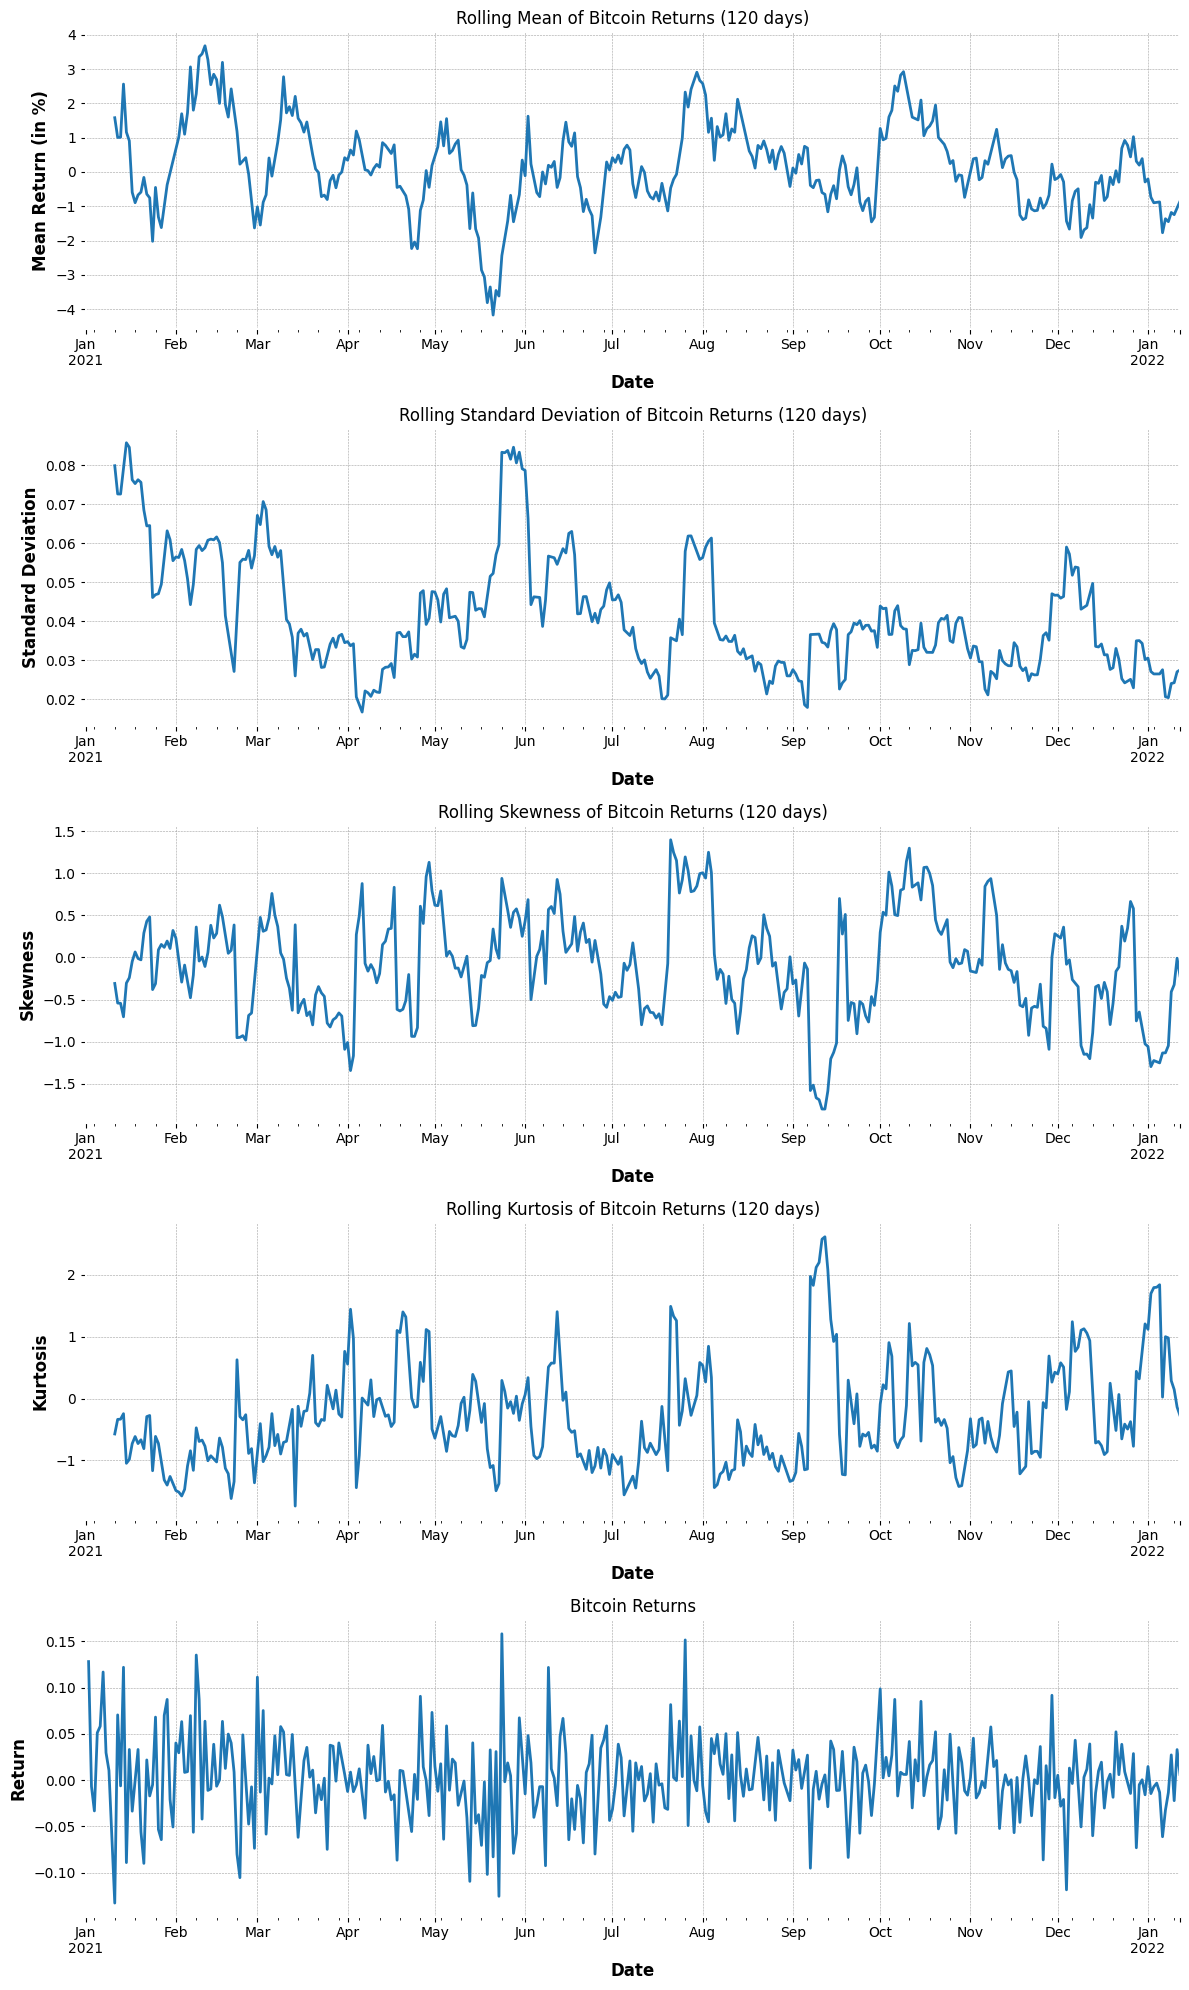

/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_94980/403130351.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample2['Log_Return'] = np.log(1 + df_sample2['Return'])


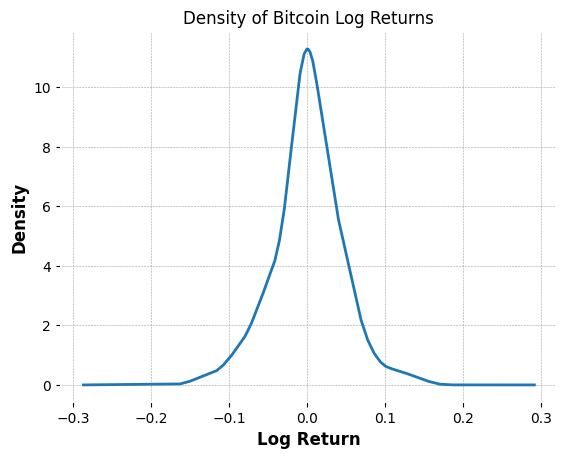

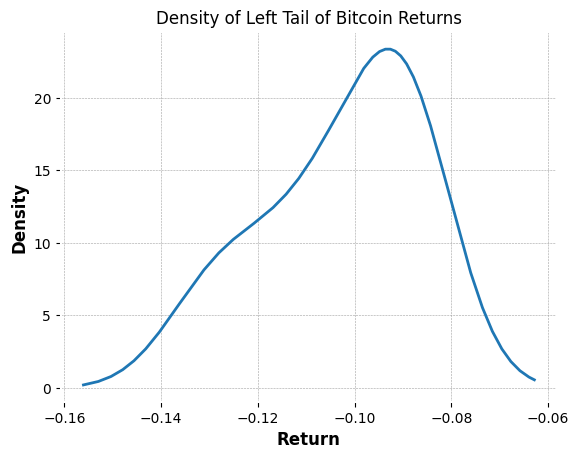

In [ ]:
df_sample2['Return'] = df_sample2['close'].pct_change()


# Define the rolling window size
rolling_window = 10

# Calculate rolling statistics
df_sample2['Rolling_Mean'] = (df_sample2['Return'].rolling(window=rolling_window).mean())*100
df_sample2['Rolling_Std'] = df_sample2['Return'].rolling(window=rolling_window).std()
df_sample2['Rolling_Skewness'] = df_sample2['Return'].rolling(window=rolling_window).apply(skew, raw=True)
df_sample2['Rolling_Kurtosis'] = df_sample2['Return'].rolling(window=rolling_window).apply(kurtosis, raw=True)

# Plotting the rolling statistics
fig, axes = plt.subplots(5, 1, figsize=(12, 20))

df_sample2['Rolling_Mean'].plot(ax=axes[0], title='Rolling Mean of Bitcoin Returns (120 days)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Mean Return (in %)')

df_sample2['Rolling_Std'].plot(ax=axes[1], title='Rolling Standard Deviation of Bitcoin Returns (120 days)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Standard Deviation')

df_sample2['Rolling_Skewness'].plot(ax=axes[2], title='Rolling Skewness of Bitcoin Returns (120 days)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Skewness')

df_sample2['Rolling_Kurtosis'].plot(ax=axes[3], title='Rolling Kurtosis of Bitcoin Returns (120 days)')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Kurtosis')

df_sample2['Return'].plot(ax=axes[4], title='Bitcoin Returns')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Return')


plt.tight_layout()
plt.show()

# Density plot of returns
df_sample2['Log_Return'] = np.log(1 + df_sample2['Return'])

# Plotting the density
df_sample2['Log_Return'].plot(kind='density', title='Density of Bitcoin Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid(True)
plt.show()
# Density plot of left tail returns
left_tail = df_sample2['Return'][df_sample2['Return'] < df_sample2['Return'].mean() - 2 * df_sample2['Return'].std()]
left_tail.plot(kind='density', title='Density of Left Tail of Bitcoin Returns')
plt.xlabel('Return')
plt.show()

In [ ]:
df_sample2

open      high       low     close         volume    Return  \
Date                                                                          
2021-01-01  28749.00  29600.00  28690.17  29021.88   55916.906624       NaN   
2021-01-02  29021.88  33000.00  28624.57  32741.38   95251.302335  0.128162   
2021-01-03  32741.39  34778.11  30300.00  32521.79  145167.682965 -0.006707   
2021-01-04  32531.53  33861.92  28130.00  31442.45  144603.259032 -0.033188   
2021-01-05  31435.65  33188.26  29900.00  33055.31  102267.752851  0.051296   
...              ...       ...       ...       ...            ...       ...   
2022-01-08  41670.96  42246.37  40501.00  41110.87   26246.459270 -0.013441   
2022-01-09  41110.87  42300.00  40520.00  42234.81   27815.292240  0.027339   
2022-01-10  42234.81  42786.70  39650.00  41301.89   50750.517960 -0.022089   
2022-01-11  41301.89  43100.00  41158.99  42667.95   38354.979670  0.033075   
2022-01-12  42667.94  43095.26  42595.68  42933.38    5589.087150  0.006221   

            Rolling_Std_20    Custom  Rolling_Mean  Rolling_Std  \
Date                                                              
2021-01-01        0.034659  0.273866           NaN          NaN   
2021-01-02        0.041927  3.056802     12.816192          NaN   
2021-01-03        0.042179 -0.159009     -0.670680          NaN   
2021-01-04        0.044205 -0.750779     -3.318821          NaN   
2021-01-05        0.043652  1.175116      5.129562          NaN   
...                    ...       ...           ...          ...   
2022-01-08        0.029179 -0.460624     -1.344078          NaN   
2022-01-09        0.029958  0.912575      2.733924          NaN   
2022-01-10        0.027087 -0.815468     -2.208889          NaN   
2022-01-11        0.028450  1.162562      3.307500          NaN   
2022-01-12        0.026604  0.233829      0.622083          NaN   

            Rolling_Skewness  Rolling_Kurtosis  Log_Return  
Date                                                        
2021-01-01               NaN               NaN         NaN  
2021-01-02               NaN               NaN    0.120590  
2021-01-03               NaN               NaN   -0.006729  
2021-01-04               NaN               NaN   -0.033751  
2021-01-05               NaN               NaN    0.050023  
...                      ...               ...         ...  
2022-01-08               NaN               NaN   -0.013532  
2022-01-09               NaN               NaN    0.026972  
2022-01-10               NaN               NaN   -0.022337  
2022-01-11               NaN               NaN    0.032540  
2022-01-12               NaN               NaN    0.006202  

[377 rows x 13 columns]

In [ ]:
df_daily.loc['2021-01-01':'2022-12-31']
df_daily1=df_daily.copy()
df_daily1.set_index('Date', inplace=True)

df_sample2=df_daily1['2021-01-01':'2022-12-31']
df_sample2

open      high       low     close         volume    Return  \
Date                                                                          
2021-01-01  28749.00  29600.00  28690.17  29021.88   55916.906624  0.009492   
2021-01-02  29021.88  33000.00  28624.57  32741.38   95251.302335  0.128162   
2021-01-03  32741.39  34778.11  30300.00  32521.79  145167.682965 -0.006707   
2021-01-04  32531.53  33861.92  28130.00  31442.45  144603.259032 -0.033188   
2021-01-05  31435.65  33188.26  29900.00  33055.31  102267.752851  0.051296   
...              ...       ...       ...       ...            ...       ...   
2022-01-08  41670.96  42246.37  40501.00  41110.87   26246.459270 -0.013441   
2022-01-09  41110.87  42300.00  40520.00  42234.81   27815.292240  0.027339   
2022-01-10  42234.81  42786.70  39650.00  41301.89   50750.517960 -0.022089   
2022-01-11  41301.89  43100.00  41158.99  42667.95   38354.979670  0.033075   
2022-01-12  42667.94  43095.26  42595.68  42933.38    5589.087150  0.006221   

            Rolling_Std_20    Custom  Rolling_Mean  Rolling_Std  \
Date                                                              
2021-01-01        0.034659  0.273866      0.875817     0.028207   
2021-01-02        0.041927  3.056802      1.006489     0.030032   
2021-01-03        0.042179 -0.159009      1.023082     0.029883   
2021-01-04        0.044205 -0.750779      0.985017     0.030143   
2021-01-05        0.043652  1.175116      1.033248     0.030341   
...                    ...       ...           ...          ...   
2022-01-08        0.029179 -0.460624     -0.027821     0.035269   
2022-01-09        0.029958  0.912575     -0.001653     0.035357   
2022-01-10        0.027087 -0.815468     -0.024836     0.035410   
2022-01-11        0.028450  1.162562      0.026622     0.035442   
2022-01-12        0.026604  0.233829     -0.003463     0.035235   

            Rolling_Skewness  Rolling_Kurtosis  
Date                                            
2021-01-01         -0.284584          4.532735  
2021-01-02          0.179706          4.915476  
2021-01-03          0.179811          5.052734  
2021-01-04          0.188006          4.822721  
2021-01-05          0.159319          4.638330  
...                      ...               ...  
2022-01-08         -0.100091          1.216826  
2022-01-09         -0.117610          1.181285  
2022-01-10         -0.099438          1.154630  
2022-01-11         -0.131542          1.149111  
2022-01-12         -0.122465          1.225821  

[377 rows x 12 columns]

In [ ]:
df_daily['Return'].plot(kind='density', title='Density of Bitcoin Returns')
plt.xlabel('Return')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


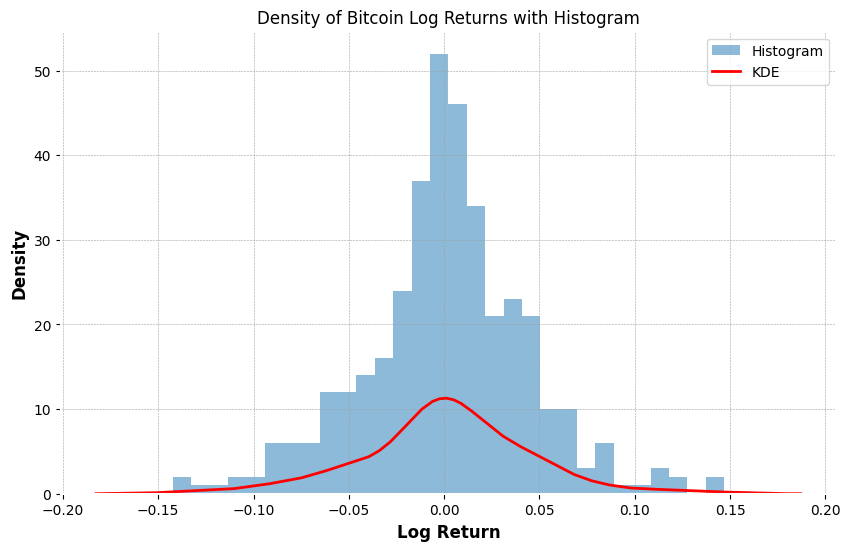

In [ ]:
import seaborn as sns

# Assuming df_sample is your DataFrame and 'Log_Return' is the column of interest
plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(df_sample2['Log_Return'], bins=30, alpha=0.5, label='Histogram')

# Overlay KDE (smoothed density plot)
sns.kdeplot(df_sample2['Log_Return'], color='red', label='KDE')

# Add titles and labels
plt.title('Density of Bitcoin Log Returns with Histogram')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


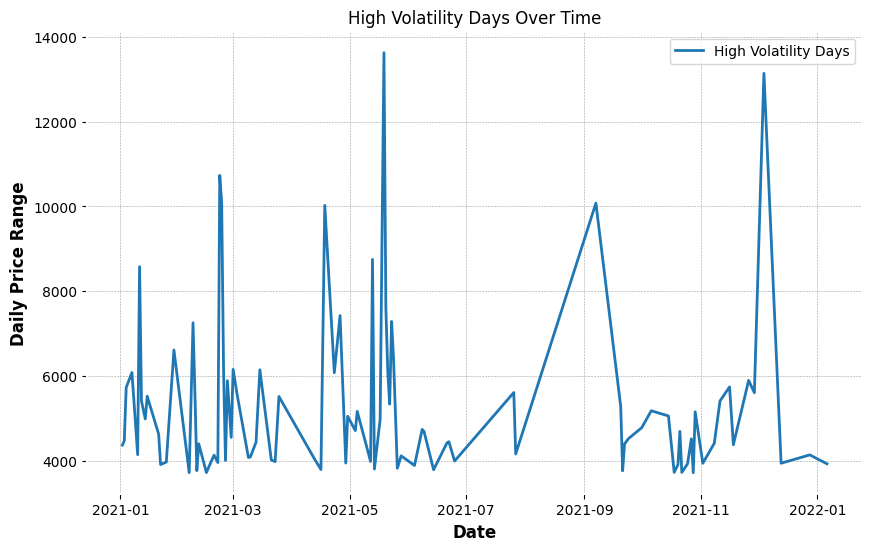

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(volatility_2021_2022.index, volatility_2021_2022, label='High Volatility Days')

plt.xlabel('Date')
plt.ylabel('Daily Price Range')
plt.title('High Volatility Days Over Time')
plt.legend()

plt.show()

In [ ]:
daily_range

Date
2018-01-01    1068.55
2018-01-02    1498.86
2018-01-03    1323.49
2018-01-04    1361.96
2018-01-05    2518.13
               ...   
2022-01-08    1745.37
2022-01-09    1780.00
2022-01-10    3136.70
2022-01-11    1941.01
2022-01-12     499.58
Freq: D, Length: 1473, dtype: float64

In [ ]:
high_volatility_days

Date
2018-01-05    2518.13
2018-01-08    3688.00
2018-01-10    1813.70
2018-01-11    3568.68
2018-01-12    1609.78
               ...   
2022-01-07    2971.30
2022-01-08    1745.37
2022-01-09    1780.00
2022-01-10    3136.70
2022-01-11    1941.01
Length: 368, dtype: float64

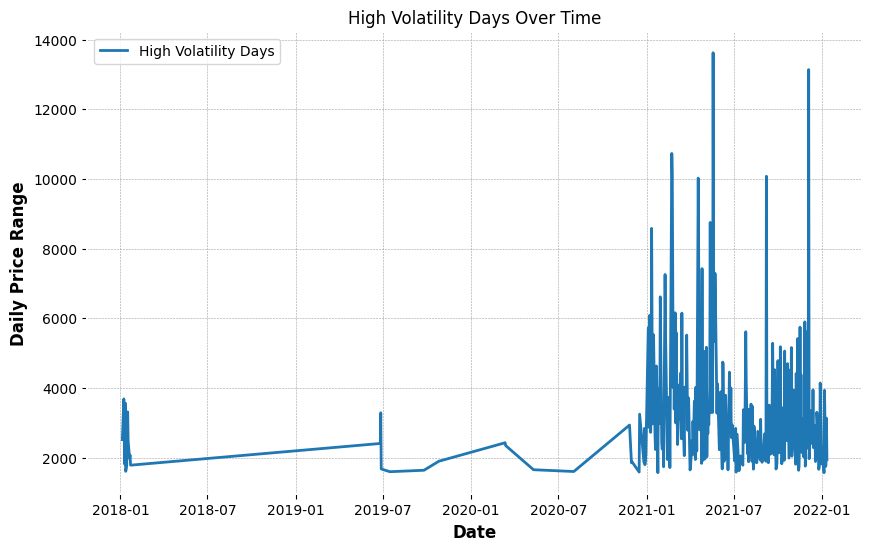

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(high_volatility_days.index, high_volatility_days, label='High Volatility Days')

plt.xlabel('Date')
plt.ylabel('Daily Price Range')
plt.title('High Volatility Days Over Time')
plt.legend()

plt.show()

In [ ]:
df

open      high       low     close      volume  Year
Date                                                                         
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13556.15  123.616013  2018
2018-01-01 05:45:00  13533.75  13550.87  13402.00  13521.12   98.136430  2018
2018-01-01 06:00:00  13500.00  13545.37  13450.00  13470.41   79.904037  2018
2018-01-01 06:15:00  13494.65  13690.87  13450.00  13529.01  141.699719  2018
2018-01-01 06:30:00  13528.99  13571.74  13402.28  13445.63   72.537533  2018
...                       ...       ...       ...       ...         ...   ...
2022-01-12 04:30:00  42713.12  42886.28  42665.26  42874.90  220.280580  2022
2022-01-12 04:45:00  42874.90  42875.05  42758.00  42790.01  138.050550  2022
2022-01-12 05:00:00  42790.00  42822.21  42693.00  42790.03  158.322150  2022
2022-01-12 05:15:00  42790.04  42819.89  42633.97  42729.29  164.488730  2022
2022-01-12 05:30:00  42729.29  42950.00  42692.84  42933.38  261.182130  2022

[140786 rows x 6 columns]

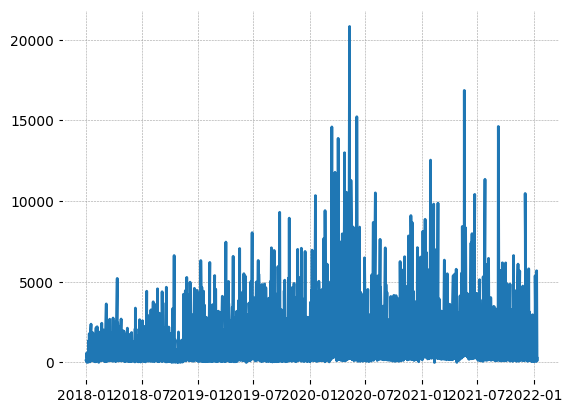

In [ ]:
plt.plot(df['volume'])


# INDICATORS
#### 1. Fibonacci Retractment
#### 2. Inchimoku Cloud
#### 3. Gaussian Process Regression
#### 4. Custom Indicator (O-C)*V

## Fibonacci Retractment

In [ ]:
def plot_fibonacci_retracement(data, start_time, end_time):

    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)

    if start_time >= end_time:
        raise ValueError("End time must be after start time.")
    if start_time not in data.index or end_time not in data.index:
        raise ValueError("Start and end times must be within the DataFrame's index range.")
    
    price_data = data['close'].loc[start_time:end_time]

    highest_point = price_data.max()
    lowest_point = price_data.min()
    price_range = highest_point - lowest_point
    
    fib_levels = {
        '23.6%': highest_point - price_range * 0.236,
        '38.2%': highest_point - price_range * 0.382,
        '50.0%': highest_point - price_range * 0.5,
        '61.8%': highest_point - price_range * 0.618,
        '100.0%': lowest_point
    }

    plt.figure(figsize=(14, 7))
    plt.plot(price_data.index, price_data, label='Price')
    
    for key, level in fib_levels.items():
        plt.axhline(level, color='red', linestyle='--', alpha=0.7, label=f'Fib Level {key} at {level:.2f}')
    
    plt.title(f'Fibonacci Retracement Levels from {start_time} to {end_time}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()




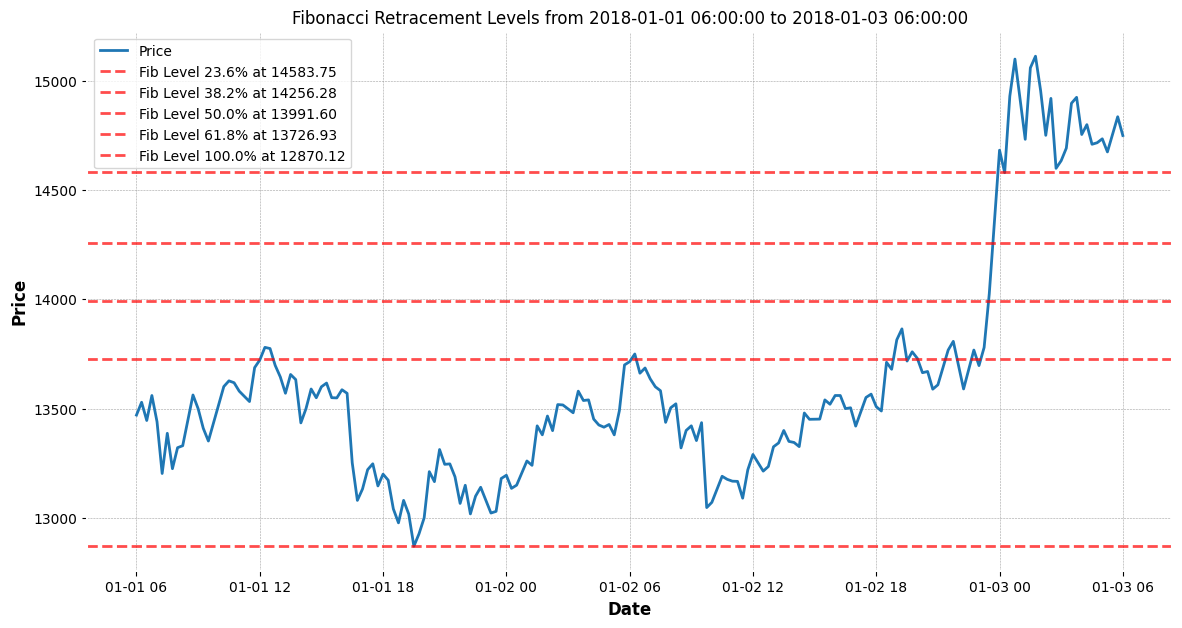

In [ ]:
# Example:
plot_fibonacci_retracement(df, '2018-01-01 06:00:00 ', '2018-01-03 06:00:00')

## Ichimoku Cloud


In [ ]:
dfs[2018]['Week'] = dfs[2018]['Date'].dt.isocalendar().week

dfw = {}

for month in dfs[2018]['Month'].unique():
    monthly_data = dfs[2018][dfs[2018]['Month'] == month]
    for week in monthly_data['Week'].unique():
        key = f"2018-{month:02d}-{week}"
        dfw[key] = monthly_data[monthly_data['Week'] == week]

In [ ]:
dfw['2018-02-5']


Date      open      high       low     close      volume  \
2947 2018-02-01 00:00:00  10094.54  10172.57  10060.01  10093.42  144.085708   
2948 2018-02-01 00:15:00  10093.42  10104.42  10025.98  10054.11   74.483408   
2949 2018-02-01 00:30:00  10061.19  10098.89  10023.00  10065.29   69.195405   
2950 2018-02-01 00:45:00  10064.00  10074.99  10005.00  10051.10   49.027040   
2951 2018-02-01 01:00:00  10052.00  10125.00  10041.00  10072.68   79.408067   
...                  ...       ...       ...       ...       ...         ...   
3326 2018-02-04 22:45:00   8543.98   8555.00   8471.68   8475.36  202.123856   
3327 2018-02-04 23:00:00   8487.98   8545.00   8400.00   8527.01  247.540551   
3328 2018-02-04 23:15:00   8527.01   8544.99   8450.00   8481.95  131.839017   
3329 2018-02-04 23:30:00   8474.68   8585.00   8474.68   8569.78  201.549714   
3330 2018-02-04 23:45:00   8568.97   8583.44   8400.00   8400.02  229.424729   

      Year  Month  Week  
2947  2018      2     5  
2948  2018      2     5  
2949  2018      2     5  
2950  2018      2     5  
2951  2018      2     5  
...    ...    ...   ...  
3326  2018      2     5  
3327  2018      2     5  
3328  2018      2     5  
3329  2018      2     5  
3330  2018      2     5  

[384 rows x 9 columns]

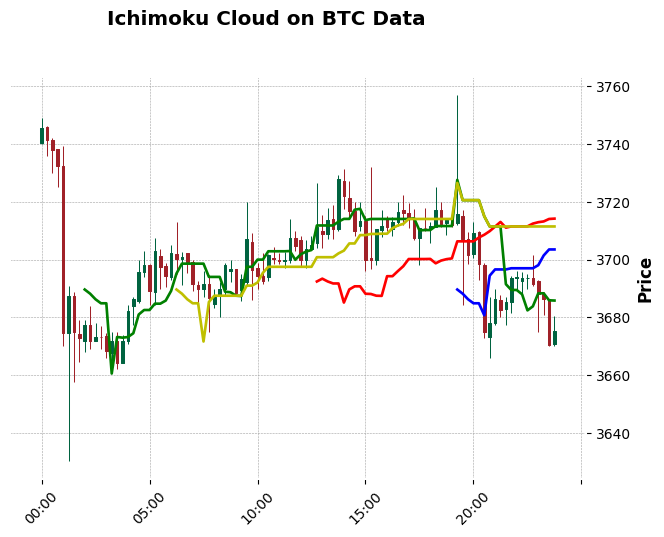

In [ ]:

def plot_ichimoku(df, start_date=None, end_date=None):

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex")

    if start_date:
        start_datetime = pd.to_datetime(start_date)
        df = df[df.index >= start_datetime]

    if end_date:
        end_datetime = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
        df = df[df.index <= end_datetime]

    if df.empty:
        raise ValueError("No data available for the specified date range")
    
    # Calculating Ichimoku components
    df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2
    df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    df['senkou_span_b'] = ((df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2).shift(26)

    add_plot = [
        mpf.make_addplot(df['senkou_span_a'], color='r'),
        mpf.make_addplot(df['senkou_span_b'], color='b'),
        mpf.make_addplot(df['tenkan_sen'], color='g'),
        mpf.make_addplot(df['kijun_sen'], color='y'),
    ]

    mpf.plot(df, type='candle', addplot=add_plot, title="Ichimoku Cloud on BTC Data", style='charles')

# Example:
plot_ichimoku(df, start_date='2019-01-01', end_date='2019-01-01') 


In [ ]:
def split_dataframes(df):
   
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

    splits = {'daily': {}, 'weekly': {}, 'monthly': {}}

    # Daily split
    for day in df.index.date:
        key = day.strftime("%Y-%m-%d")
        if key not in splits['daily']:
            splits['daily'][key] = df[df.index.date == day]

    # Weekly split
    df['Week'] = df.index.isocalendar().week
    df['Year'] = df.index.year
    for year_week, weekly_data in df.groupby(['Year', 'Week']):
        key = f"{year_week[0]}-W{year_week[1]}"
        splits['weekly'][key] = weekly_data.drop(columns=['Week', 'Year'])

    # Monthly split
    for month, monthly_data in df.groupby(df.index.month):
        key = month.strftime("%Y-%m")
        splits['monthly'][key] = monthly_data

    return splits

# split_df = split_dataframes(df)

## (O-C)*Volume

In [ ]:
df['strat_1']=(df['open']-df['close'])*df['volume']
df_5min['strat_1']=(df_5min['open']-df_5min['close'])*df_5min['volume']

/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_62691/2142148740.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['strat_1'] = (filtered_df['open'] - filtered_df['close']) * filtered_df['volume']


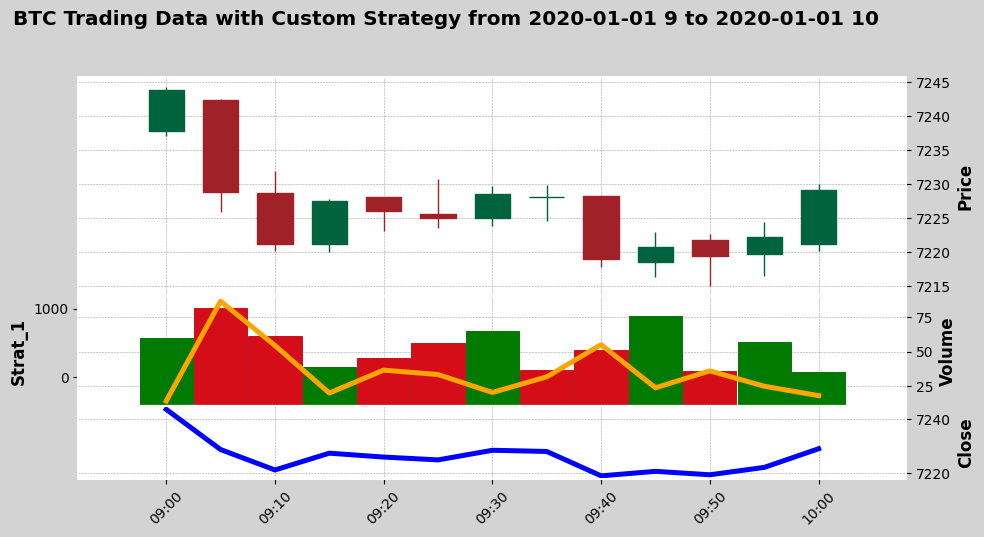

In [ ]:

def plot_custom_strategy(df, start_date, end_date, start_hour=None, end_hour=None):
    
    start_datetime = pd.to_datetime(start_date)
    end_datetime = pd.to_datetime(end_date) + pd.Timedelta(days=1)

    if start_hour is not None:
        start_datetime += pd.Timedelta(hours=start_hour)
    if end_hour is not None:
        end_datetime += pd.Timedelta(hours=end_hour) - pd.Timedelta(days=1)

    filtered_df = df[(df.index >= start_datetime) & (df.index <= end_datetime)]

    filtered_df['strat_1'] = (filtered_df['open'] - filtered_df['close']) * filtered_df['volume']

    add_plot = [
        mpf.make_addplot(filtered_df['strat_1'], panel=1, color='orange', ylabel='Strat_1'),
        mpf.make_addplot(filtered_df['close'], panel=2, color='blue', ylabel='Close')
    ]

    mpf_style = mpf.make_mpf_style(base_mpf_style='charles', rc={'figure.facecolor': 'lightgray'})

    mpf.plot(filtered_df,
             type='candle',
             style=mpf_style,
             addplot=add_plot,
             figratio=(2,1),
             volume=True,
             title=f"BTC Trading Data with Custom Strategy from {start_date} {start_hour or ''} to {end_date} {end_hour or ''}",
             panel_ratios=(6,3,2))

plot_custom_strategy(df_5min, '2020-01-01', '2020-01-01', start_hour=9, end_hour=10)  

## Gaussian Process Regression

In [ ]:
def optimize_and_plot_gaussian_process(data, start_date, end_date):
   
    data_filtered = data[(data.index >= start_date) & (data.index <= end_date)]
    dates = data_filtered.index
    prices = data_filtered['close'].values

    X = np.arange(len(prices)).reshape(-1, 1)
    y = prices

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    gp.fit(X_train, y_train)

    y_pred, sigma = gp.predict(X, return_std=True)

    plt.figure()
    plt.plot(dates, y, 'r', markersize=1, label='Observations')
    plt.plot(dates, y_pred, 'b-', label='Prediction')
    plt.fill_between(dates, y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.5, label='95% Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('BTC Price')
    plt.title('Gaussian Process Regression on BTC Data')
    plt.legend()
    plt.show()




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


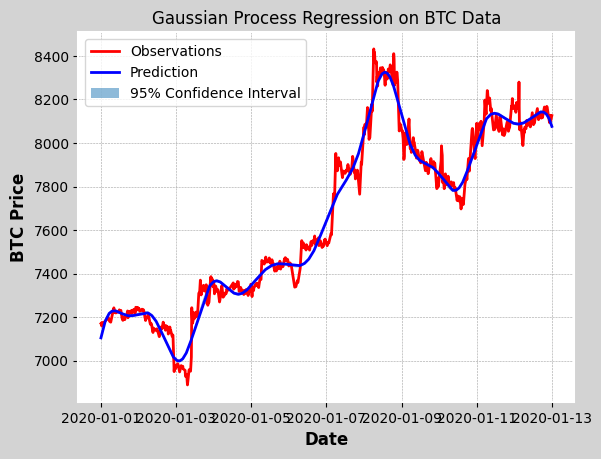

In [ ]:
# Example
optimize_and_plot_gaussian_process(df, '2020-01-01', '2020-01-13')


In [ ]:
def optimize_and_plot_gaussian_process(data, start_date, end_date):
   
    data_filtered = data[(data.index >= start_date) & (data.index <= end_date)]
    dates = data_filtered.index
    prices = data_filtered['close'].values

    X = np.arange(len(prices)).reshape(-1, 1)
    y = prices

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    gp.fit(X_train, y_train)

    y_pred, sigma = gp.predict(X, return_std=True)

    plt.figure()
    plt.plot(dates, y, 'r', markersize=1, label='Observations')
    plt.plot(dates, y_pred, 'b-', label='Prediction')
    plt.fill_between(dates, y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.5, label='95% Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('BTC Price')
    plt.title('Gaussian Process Regression on BTC Data')
    plt.legend()
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a

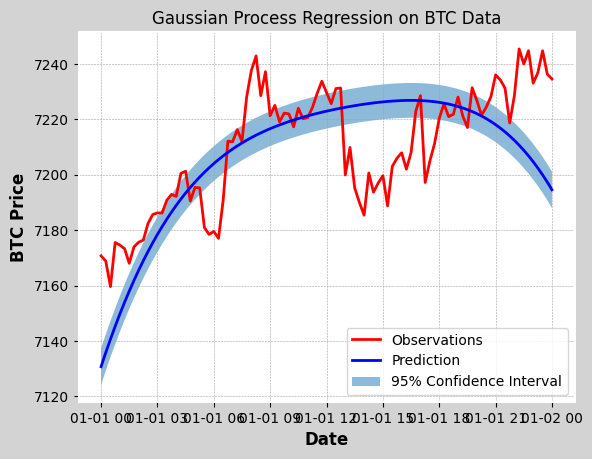

In [ ]:
optimize_and_plot_gaussian_process(df, '2020-01-01', '2020-01-2')